# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *
from fit_GLM import *
# pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:43446',
 'object_store_address': '/tmp/ray/session_2021-12-08_12-01-39_194258_97956/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-08_12-01-39_194258_97956/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-12-08_12-01-39_194258_97956',
 'metrics_export_port': 56375,
 'node_id': 'b68105f199a1fd197d23d25d0e45d9daf0e688b8a4502931ffa10c2f'}

In [3]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
args['date_ani'] = '110421/J569LT'# args['date_ani']
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=False
params_m1,file_dict,_ = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_m1)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_m1)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_m1, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params_m1['move_features']))


Done Loading Unaligned data
Model: 1, move_features: None


In [2]:
dataset_type = 'test'
def load_Kfold_forPlots(params, Kfold=0, dataset_type='test', thresh_fr = 1, tuning_thresh = .2):
    params['do_norm']=False
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
    train_idx = train_idx_list[Kfold]
    test_idx = test_idx_list[Kfold]
    data = load_Kfold_data(data,train_idx,test_idx,params)
    locals().update(data)
    locals().update(params)

    if params['free_move']:
        move_train = np.hstack((data['train_th'][:, np.newaxis], data['train_phi'][:, np.newaxis],data['train_roll'][:, np.newaxis], data['train_pitch'][:, np.newaxis]))
        move_test = np.hstack((data['test_th'][:, np.newaxis], data['test_phi'][:, np.newaxis],data['test_roll'][:, np.newaxis], data['test_pitch'][:, np.newaxis]))
        model_move = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis],data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
        model_move = (model_move - np.nanmean(model_move,axis=0))
        move_test = model_move[test_idx]
        move_train = model_move[train_idx]
    else:
        move_train = np.hstack((data['train_th'][:, np.newaxis], data['train_phi'][:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
        move_test = np.hstack((data['test_th'][:, np.newaxis], data['test_phi'][:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
        model_move = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))
    
    if dataset_type == 'train':
        nsp_raw = data['train_nsp']
        move_data = move_train.copy()
    else: 
        nsp_raw = data['test_nsp']
        move_data = move_test.copy()
        
    if params['free_move']:
        spk_percentile2 = np.arange(.125,1.125,.25)
        quartiles = np.arange(0,1.25,.25)
        tuning_curves = np.zeros((data['model_nsp'].shape[1],len(titles),len(quartiles)-1))
        tuning_stds = np.zeros((data['model_nsp'].shape[1],len(titles),1))
        tuning_curve_edges = np.zeros((data['model_nsp'].shape[1],len(titles),len(quartiles)-1))
        ax_ylims = np.zeros((data['model_nsp'].shape[-1],len(titles)))
        for i,modeln in enumerate(range(len(titles))):
            for celln in np.arange(data['model_nsp'].shape[1]):
                metric = move_data[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
                stat_std, _, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='std',bins=nranges)
                tuning_curves[celln,modeln] = stat_range/params['model_dt']
                edge_mids = np.quantile(metric,spk_percentile2)
                tuning_curve_edges[celln,modeln] = edge_mids
                tuning_stds[celln,modeln] = stat_std.max()
            ax_ylims[:,modeln] = np.nanmax(tuning_curves[:,modeln],axis=-1)
        tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.max(tuning_curves,axis=-1,keepdims=True)+np.min(tuning_curves,axis=-1,keepdims=True))
        avg_fr = np.mean(tuning_curves,axis=(-1,-2)).squeeze()

        tuning_sig = tc_mod.copy()
        tuning_sig[avg_fr<thresh_fr,:,0] = np.nan
        tuning_sig2 = np.any(tuning_sig>tuning_thresh,axis=1).squeeze()
        tuning_idx = np.where(tuning_sig2)[0]
    else: 
        tuning_curves=tuning_stds=tuning_curve_edges=ax_ylims=tc_mod=avg_fr=tuning_sig=tuning_sig2=tuning_idx = None
    return move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx
# move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=0, dataset_type='test')

# Loading Trained Networks

In [13]:
GLM_LinVis = ioh5.load(params['save_model_Vis']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))

In [16]:
GLM_LinVis[key].shape

(128, 1200)

In [18]:
state_dict = l1.state_dict()
for key in state_dict.keys():
    if 'posNN' not in key:
        state_dict[key] = torch.from_numpy(GLM_LinVis[key].astype(np.float32))
l1.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
##### Loading Movement Trained Networks #####
a = 0; l = 0
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))

l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        meanfr=params['meanbias'],init_sta=params['sta_init'],
                        train_shifter=params['train_shifter'],
                        LinMix=False,NonLinLayer=params['NonLinLayer'], device=device,).to(device)


GLM_Network = GLM_VisMov_Mul
key_list = ['sta_all','bias', 'w_move','biasm']

param_dict = {}
for (pname, param),key in zip(l1.named_parameters(),key_list):
    if key == 'sta_all':
        param_dict[pname] = torch.from_numpy(GLM_Network[key].reshape(data['model_nsp'].shape[-1],-1).astype(np.float32))
    else: 
        param_dict[pname] = torch.from_numpy(GLM_Network[key].astype(np.float32))
l1.load_state_dict(param_dict)

# Single Training

In [5]:
lr = 1e-2
for n in range(12000):
    lr = lr*.9999
lr

0.0030117613959687113

In [13]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# args['date_ani'] = '110421/J569LT'# args['date_ani']
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=False
# args['NoL1']=True
params,file_dict,_ = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data
Model: 1, move_features: None


In [39]:
# params['alphas_m'] = np.array([2])
a = 0
Nepochs=5000
nlam=1; nalph=1
track_all=True
# params['lr_m'] = [1e-2, 1e-2]
# params['lr_b'] = [1e-2, 1e-2]
# params['lr_g'] = [1e-2, 1e-2]

# params['lr_w'] = [1e-2, 1e-3]
params['alphas'] = np.array([.0001])
# params['nalph'] = len(params['alphas'])
# params['LinMix'] = False
params['lambdas'] = np.logspace(-3, 5, 40)[23:24]
params['nlam'] = len(params['lambdas'])
# params['lambdas_m'] = np.array(nlam*[0])
# params['lambdas_m'] = np.hstack((np.logspace(-3, 5, 10)[0], np.logspace(-3, 5, 20)))
# params['NonLinLayer'] = False

GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size))
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
GLM_CV['tloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['vloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['r2_test']         = np.zeros((params['nalph'], params['nlam'], output_size))

for a, reg_alph in enumerate(tqdm(params['alphas'],leave=True)):
    if params['MovModel'] == 1:
        pbar = tqdm(params['lambdas'])
    elif (params['MovModel'] != 1):
        pbar = tqdm(params['lambdas_m'])
    
    for l, reg_lam in enumerate(pbar):
        l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, l, a, params)
        if (a==0) & (l==0):
            for name, p in l1.named_parameters():
                GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
        elif (l!=0) & (params['MovModel']==1):
            l1.load_state_dict(state_dict)

        vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None,track_all=track_all)
        model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{}.pth'.format(model_type, params['WC_type'], int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'], a, l, Kfold)

        for name, p in l1.named_parameters():
            GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()

        if (l == 0) & (params['MovModel']==1):
            state_dict = l1.state_dict()

        GLM_CV['tloss_trace_all'][a, l] = tloss_trace.T
        GLM_CV['vloss_trace_all'][a, l] = vloss_trace.T
        
        pred = l1(xte, xtem, shift_in_te)
        GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
        GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
        out = l1(xtr, xtrm, shift_in_tr)
        GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T

malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][malph,mlam,cellnum])[:,params['bin_length']:-params['bin_length']].T
GLM_Data['r2_test']= np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(-0.5, 39.5, 29.5, -0.5)

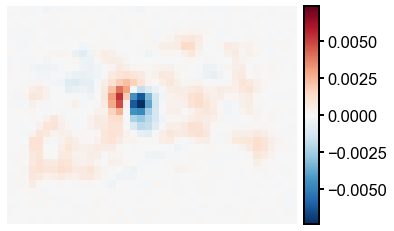

In [41]:

sta_all = GLM_CV['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])
celln = 25
fig,ax = plt.subplots()
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

In [9]:
for key in Epoch_GLM.keys():
    print(key,Epoch_GLM[key].shape)

Cell_NN.0.weight (5000, 128, 1200)
Cell_NN.0.bias (5000, 128)


In [ ]:
save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis', int(params['model_dt']*1000), 1, 1, 12000, Kfold)
GLM_Vis = ioh5.load(save_datafile)

KeyError: 'moveW_mul'

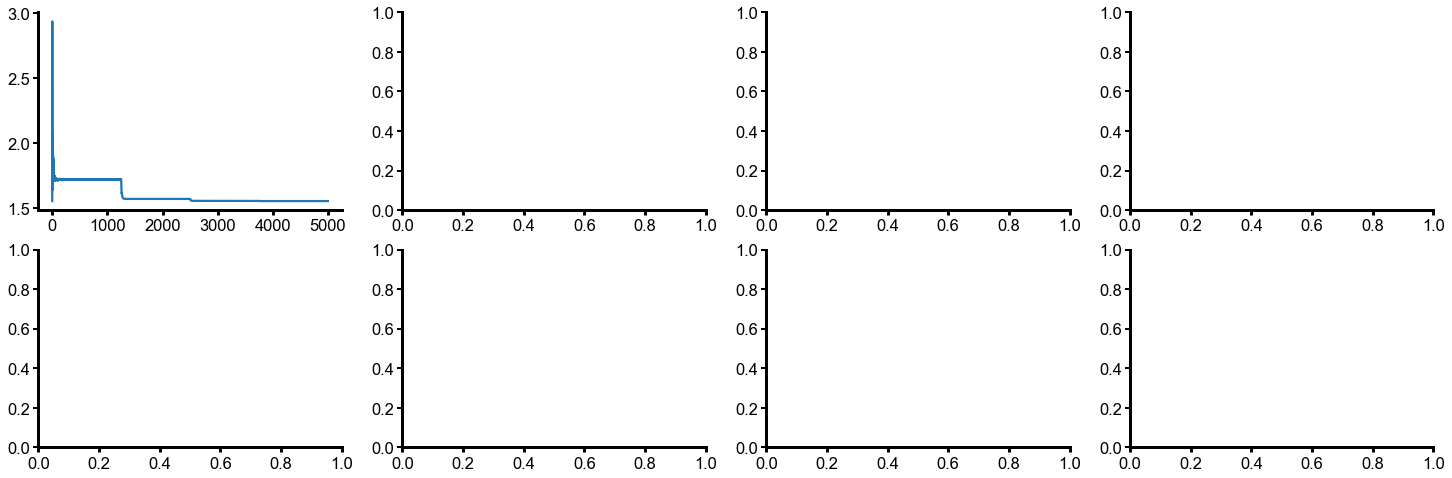

In [22]:
celln = 126
clrs = ['blue','orange','green','red','magenta']
sta_all = GLM_Data['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])
fig, axs = plt.subplots(2,4,figsize=(25,8))
axs = axs.flatten()
ax = axs[0]
ax.plot(GLM_Data['vloss_trace_all'][ celln])
# ax.plot(vloss_trace[:, celln])

ax = axs[1]
for modeln in range(len(titles)):
    ax.plot(Epoch_GLM['moveW_mul'][:,celln,modeln],c=clrs[modeln],label=titles[modeln],ls='-')
    ax.plot(Epoch_GLM['moveW_add'][:,celln,modeln],c=clrs[modeln],label=titles[modeln],ls='--')
ax.legend(bbox_to_anchor=(1.01, .9))

ax = axs[2]
ax.plot(Epoch_GLM['biasm_add'][:,celln],ls='-',label='add')
ax.plot(Epoch_GLM['biasm_mul'][:,celln],ls='--',label='mul')
ax.legend()

ax = axs[3]
ax.plot(Epoch_GLM['gamma'][:,celln])

ax = axs[4]
for modeln in range(2):
    ax.plot(medfilt(move_test[:,modeln],7),c=clrs[modeln],label=titles[modeln])
ax.plot((pred_smooth[:,celln]-np.mean(pred_smooth[:,celln]))/np.std(pred_smooth[:,celln]),'k')

ax = axs[5]
for modeln in range(2,4):
    ax.plot(medfilt(move_test[:,modeln],7),c=clrs[modeln],label=titles[modeln])
ax.plot((pred_smooth[:,celln]-np.mean(pred_smooth[:,celln]))/np.std(pred_smooth[:,celln]),'k')


ax = axs[6]
ax.plot(sp_smooth[:,celln])
ax.plot(pred_smooth[:,celln])
ax.set_title('Vis r2:{:.02f} \n AddMul r2:{:.02f}, gamma:{:.02f}'.format(GLM_Vis['r2_test'][celln],r2_test[celln],Epoch_GLM['gamma'][-1,celln]))

ax = axs[7]
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

plt.tight_layout()


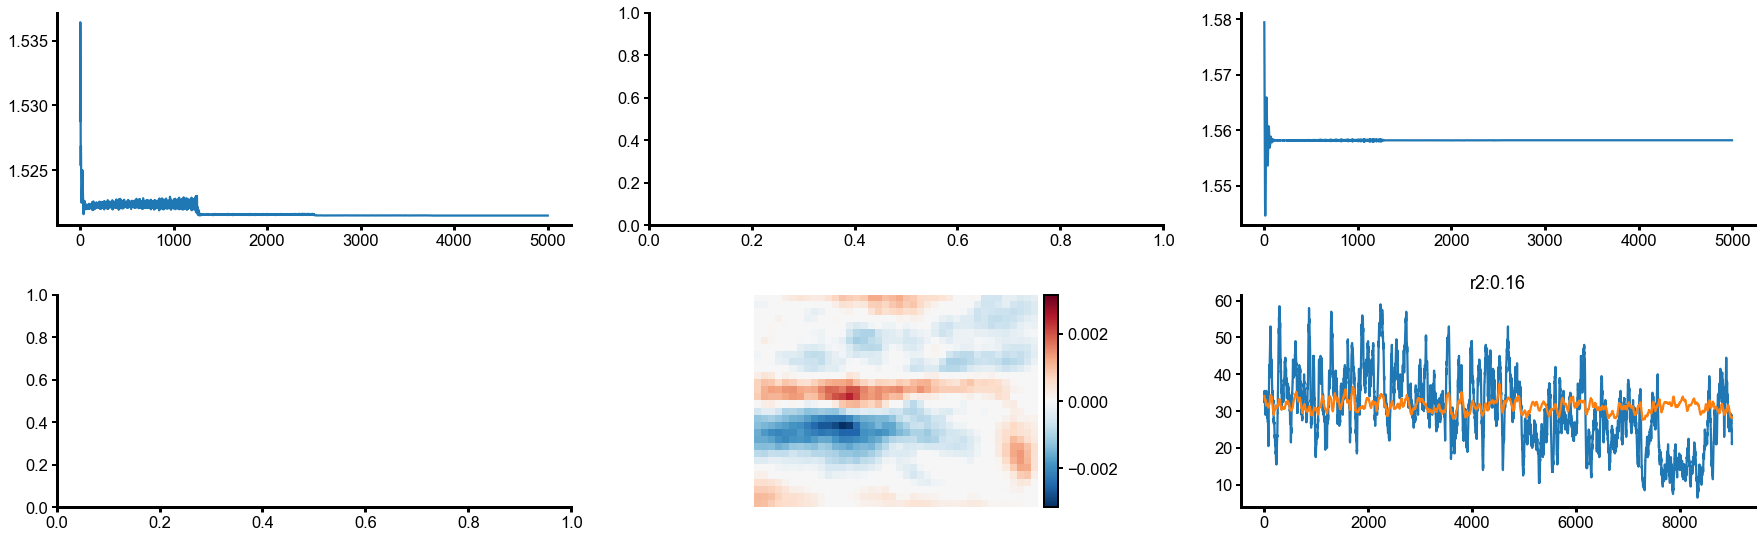

In [48]:
celln = 126
clrs = ['blue','orange','green','red','magenta']
sta_all = GLM_Data['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])

fig, axs = plt.subplots(2,3,figsize=(25,8))
axs = axs.flatten()
ax = axs[0]
ax.plot(GLM_Data['vloss_trace_all'][ celln])
# ax.plot(vloss_trace[:, celln])

# ax = axs[1]
# for modeln in range(len(titles)):
#     ax.plot(Epoch_GLM['move_weights'][:,celln,modeln],c=clrs[modeln],label=titles[modeln])
# ax.legend()
ax = axs[2]
ax.plot(Epoch_GLM['Cell_NN.0.bias'][:,celln])

# ax = axs[3]
# for modeln in range(2):
#     ax.plot(medfilt(move_test[:,modeln],7),c=clrs[modeln],label=titles[modeln])

# ax.plot((pred_smooth[:,celln]-np.mean(pred_smooth[celln]))/np.std(pred_smooth[:,celln]),'k')

# ax = axs[4]
# for modeln in range(2,4):
#     ax.plot(medfilt(move_test[:,modeln],7),c=clrs[modeln],label=titles[modeln])
# ax.plot((pred_smooth[:,celln]-np.mean(pred_smooth[:,celln]))/np.std(pred_smooth[:,celln]),'k')

ax = axs[4]
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

ax = axs[5]
ax.plot(sp_smooth[:,celln])
ax.plot(pred_smooth[:,celln])
ax.set_title('r2:{:.02f}'.format(GLM_Data['r2_test'][celln]))

plt.tight_layout()

In [42]:
np.sum(Epoch_GLM['gamma'][-1]<.5),np.sum(Epoch_GLM['gamma'][-1]>.5)

(122, 1)

In [ ]:
# if params['do_shuffle']:
#     save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, Nepochs)
# else:
#     save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, Nepochs)
# ioh5.save(save_datafile, GLM_Data)

0.15122625847370352

In [ ]:
plt.plot(loss_regcv[0,:,126])

In [ ]:
xtrm.shape,l1.biasm_all.shape

In [ ]:
(xtrm+l1.biasm_all).shape

In [ ]:
torch.prod(xtrm,dim=1,keepdim=True).shape

In [ ]:
plt.plot(torch.exp(xtrm.matmul(l1.move_weights.T) + l1.bias_m)[:,126].clone().cpu().detach())

In [ ]:
celln = 126
plt.figure()
plt.plot(tloss_trace_all2[celln,:])
plt.plot(vloss_trace_all2[celln,:])

# w_move1 = l1.move_weights.clone().detach().cpu().numpy()
# plt.figure()
# plt.bar(np.arange(4),w_move1[celln])

# plt.figure()
# bias_m = l1.bias_m.clone().detach().cpu().numpy()
# plt.plot(bias_m)

In [ ]:
celln = 99
bin_length=40
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))

fig,ax = plt.subplots(figsize=(20,5))
sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
pred_smooth = ((np.convolve(pred_test[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)

pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_Mul))*model_dt,pred_smooth_Mul,'g', lw=2)

r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
r2 = np.corrcoef(sp_smooth,pred_smooth)[0,1]**2
r2,r2_Mul

In [ ]:
celln = 25
fig, ax = plt.subplots(figsize=(20,10))
for modeln in range(len(titles)):
    ax.bar(modeln, w_move[celln,modeln])
    ax.set_xticks(np.arange(0,len(titles)))
    ax.set_xticklabels(titles,rotation = 45)
    ax.set_ylabel('GLM Weight')
    ax.set_title('Add Weights')

# Plotting

## Single Model Plot

In [39]:
Kfold=0
# GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs,Kfold))
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
# GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
# GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))


In [ ]:
cells = np.arange(30)
fig,axs_all = plt.subplots(len(cells),5,figsize=(20,3*len(cells)))
for n,celln in enumerate(cells):
    crange = np.max(np.abs(GLM_VisMov_Vis['sta_all'][celln]))
    axs = axs_all[n,:]
    for m,ax in enumerate(axs):
        im = ax.imshow(GLM_VisMov_Vis['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
        if m == (params['nt_glm_lag']-1):
            cbar = add_colorbar(im)
        ax.axis('off')
plt.tight_layout()

In [57]:
celln = 30
r2_Vis[:,celln],r2_Add[:,celln],r2_Mul[:,celln]

(array([0.13211706, 0.29045323, 0.33781077]),
 array([0.23759689, 0.33255675, 0.40301108]),
 array([0.30337428, 0.46595199, 0.44634379]))

## Scatter Plot

In [14]:
Nepochs = 5000
params['NKfold']=1

r2_Mot = np.zeros((params['NKfold'],output_size))
r2_Vis = np.zeros((params['NKfold'],output_size))
r2_Add = np.zeros((params['NKfold'],output_size))
r2_Mul = np.zeros((params['NKfold'],output_size))
r2_AddMul = np.zeros((params['NKfold'],output_size))
for Kfold in range(params['NKfold']):
    params_m1,_,_ = load_params(1,Kfold,args,debug=True)
    params_m2,_,_ = load_params(2,Kfold,args,debug=True)
    params_m3,_,_ = load_params(3,Kfold,args,debug=True)
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    # GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs,Kfold))
    GLM_VisMov_Vis = ioh5.load(params_m1['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000, Kfold))
    GLM_VisMov_Add = ioh5.load(params_m2['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    GLM_VisMov_Mul = ioh5.load(params_m3['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 3, Nepochs,Kfold))
    # GLM_VisMov_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))
    # r2_Mot[Kfold] = GLM_VisMov_Mot['r2_test'].copy()
    r2_Vis[Kfold] = GLM_VisMov_Vis['r2_test'].copy()
    r2_Add[Kfold] = GLM_VisMov_Add['r2_test'].copy()
    r2_Mul[Kfold] = GLM_VisMov_Mul['r2_test'].copy()
    # r2_AddMul[Kfold] = GLM_VisMov_AddMul['r2_test'].copy()

Done Loading Unaligned data


/tmp/ipykernel_97956/1447922597.py:8: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
/tmp/ipykernel_97956/1447922597.py:9: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
/tmp/ipykernel_97956/1447922597.py:10: RuntimeWarning: Mean of empty slice
  yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]
/tmp/ipykernel_97956/1447922597.py:35: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
/tmp/ipykernel_97956/1447922597.py:36: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]


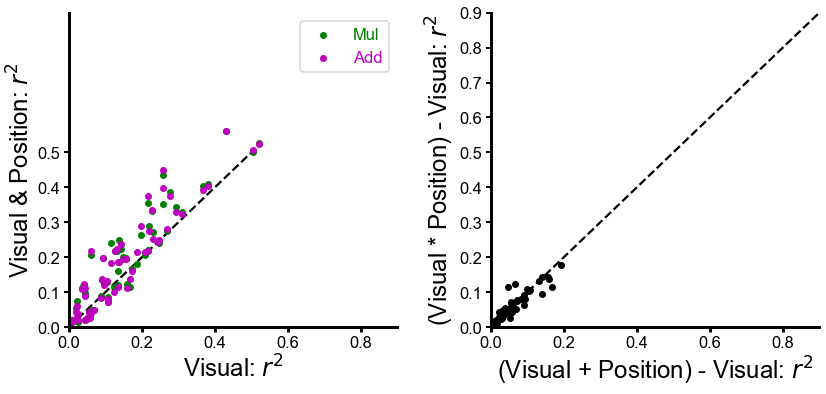

In [17]:
a = 0; l = 0
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, .9)
ax.scatter(xvals,yvals,30,c='g', label='Mul')
ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],.5),np.linspace(lims[0],.5),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,.6,.1))
ax.set_yticklabels(np.round(np.arange(0,.6,.1),decimals=1))
ax.set_ylim([0,.9])
ax.set_xlim([0,.9])

leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)

xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, .9)
ax = axs[1]
ax.scatter(xvals,yvals,30,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylim([0,.9])
ax.set_xlim([0,.9])

# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)

plt.tight_layout()
# fig.savefig(fig_dir/'VisMov_ADDMUL_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



# TODO: Shuffle movement

In [12]:
thresh_fr = 1
r2_thresh=.05
r2_sigP = np.nanmean(r2_Mot,axis=0)
r2_sigV = np.nanmean(r2_Vis,axis=0)
r2_sig2 = (r2_sigP>r2_thresh) & (r2_sigV>r2_thresh) & (avg_fr>thresh_fr)
r2_idx = np.where(r2_sig2)[0]
np.sum(r2_sig2)

/tmp/ipykernel_578284/4257152574.py:4: RuntimeWarning: Mean of empty slice
  r2_sigV = np.nanmean(r2_Vis,axis=0)


0

/tmp/ipykernel_578284/937780489.py:6: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Add,axis=0)#[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
/tmp/ipykernel_578284/937780489.py:7: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0)#[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]


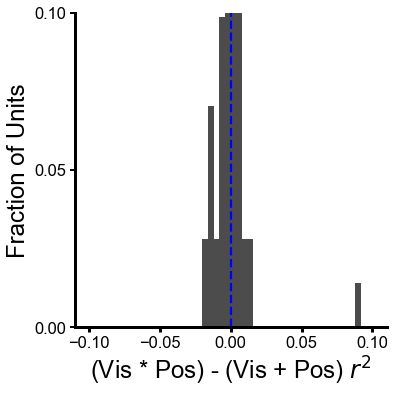

In [13]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
bin_length=40
fig, ax = plt.subplots(1,figsize=(6,6))
xvals = np.nanmean(r2_Add,axis=0)#[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)#[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]

dwidth = .004
count,edges = np.histogram(yvals-xvals, bins=np.arange(-.1,.1+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='k',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(yvals-xvals),c='b',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('(Vis * Pos) - (Vis + Pos) $r^2$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
ax.set_yticks(np.arange(0,.2,.05))
ax.set_ylim(0,.1)
plt.tight_layout()
# fig.savefig(fig_dir/'Add_M_Mul_Hist_binlen{}_Kfold{:02d}.pdf'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight', dpi=300)

In [ ]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
bin_length=40
fig, ax = plt.subplots(1,figsize=(6,6))
xvals = np.nanmean(r2_Add,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
yvals2 = np.nanmean(r2_AddMul,axis=0)[r2_sig2]

dwidth = .004
count,edges = np.histogram(yvals2-xvals, bins=np.arange(-.04,.04+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='r',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(yvals2-xvals),c='r',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('Mix - (Vis + Pos) $r^2$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
ax.set_yticks(np.arange(0,.2,.05))
ax.set_ylim(0,.1)
plt.tight_layout()

dwidth = .004
fig, ax = plt.subplots(1,figsize=(6,6))
count,edges = np.histogram(yvals2-yvals, bins=np.arange(-.04,.04+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='b',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(yvals-yvals),c='b',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('Mix - (Vis * Pos) $r^2$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
ax.set_yticks(np.arange(0,.2,.05))
ax.set_ylim(0,.1)
plt.tight_layout()
# fig.savefig(fig_dir/'Add_M_Mul_Hist_binlen{}_Kfold{:02d}.pdf'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight', dpi=300)

In [ ]:
dwidth = .04
fig, ax = plt.subplots(1,figsize=(6,6))
gammas = GLM_VisMov_AddMul['gamma_trace_all'][:,-1][r2_sig2]
count,edges = np.histogram(gammas, bins=np.arange(0,1+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='k',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(gammas),c='r',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('$\gamma$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
# ax.set_yticks(np.arange(0,.2,.05))
# ax.set_ylim(0,.1)
ax.set_xticks(np.arange(.1,1.1,.2), minor=True)
plt.tight_layout()
# fig.savefig(fig_dir/'Gamma_Hist_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight', dpi=300)

In [ ]:
plt.plot(xvals - yvals)
plt.axhline(y=0)

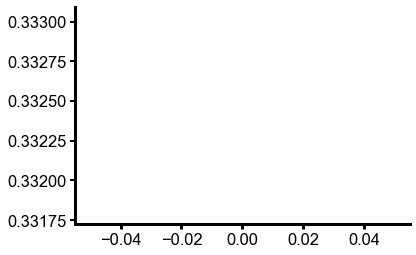

In [38]:
celln = 25
plt.plot(GLM_VisMov_Add['loss_regcv'][0,:,celln])
plt.plot(GLM_VisMov_Mul['loss_regcv'][0,:,celln])

## Comparison Plots

In [46]:
GLM_Vis['pred_cv'].shape

(128, 9081)

In [17]:
save_pdf = False

ncells = data['model_nsp'].shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
spk_percentile2 = np.arange(.125,1.125,.25)

fontsize = 24
params_m1,_,_ = load_params(1,Kfold,args,debug=True)
params_m2,_,_ = load_params(2,Kfold,args,debug=True)
params_m3,_,_ = load_params(3,Kfold,args,debug=True)
move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_Vis = ioh5.load(params_m1['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
GLM_Add = ioh5.load(params_m2['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
GLM_Mul = ioh5.load(params_m3['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 3, Nepochs,Kfold))
locals().update(params)
GLM_Vis['sta_all'] = GLM_VisMov_Vis['Cell_NN.0.weight'].reshape((ncells,params['nt_glm_lag'],)+params['nks'])
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=0, arr=data['test_nsp'])[bin_length:-bin_length]
pred_smooth_Vis = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Vis['pred_cv'])[:,bin_length:-bin_length].T
pred_smooth_Add = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Add['pred_cv'])[:,bin_length:-bin_length].T
pred_smooth_Mul = np.apply_along_axis(lambda m: np.convolve(m, np.ones(bin_length), mode='same')/(bin_length * params['model_dt']), axis=1, arr=GLM_Mul['pred_cv'])[:,bin_length:-bin_length].T

r2_Vis = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Vis[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
r2_Add = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Add[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
r2_Mul = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth_Mul[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])

pbar = tqdm([21,25,49,51,61,62,88,117,121,126]) # [12,13,20,25,49,51]) # 
# pbar = tqdm(np.arange(model_nsp.shape[-1]))
pdf_name = fig_dir/ 'VisMov_{}_dt{:03d}_Lags{:02d}_Kfold{:02d}_CellSummary.pdf'.format('Pytorch_NLVis_AM',int(params['model_dt']*1000),params['nt_glm_lag'],Kfold)
if save_pdf:
    pdf = PdfPages(pdf_name)
for n, celln in enumerate(pbar): 
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(params['nt_glm_lag'])])
    axs2b = fig2.add_subplot(spec2[0,1])
    axs3a = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    f2_ax6 = fig2.add_subplot(spec2[1, :5//2+1])
    f2_ax7 = fig2.add_subplot(spec2[1, (5//2+1):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    f2_ax8b = fig2.add_subplot(spec2[2,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_Vis['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_Vis['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')


    f2_ax6.plot(np.arange(len(sp_smooth[:,celln]))*params_m1['model_dt'],sp_smooth[:,celln], 'k', lw=2)
    f2_ax6.plot(np.arange(len(pred_smooth_Vis[:,celln]))*params_m1['model_dt'],pred_smooth_Vis[:,celln],'g', lw=2,label='Vis')
    f2_ax6.plot(np.arange(len(pred_smooth_Add[:,celln]))*params_m2['model_dt'],pred_smooth_Add[:,celln],'b', lw=2, label='Vis+Mov')
    f2_ax6.plot(np.arange(len(pred_smooth_Mul[:,celln]))*params_m3['model_dt'],pred_smooth_Mul[:,celln],'r', lw=2, label='Vis*Mov')
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax6.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
    # r2_Vis = (np.corrcoef(sp_smooth_vis,pred_smooth_Vis)[0,1])**2
    # r2_Mul = GLM_VisMov_Mul['r2_test'][0,mlam_NLVis[celln],celln] #(np.corrcoef(sp_smooth_NLvis,pred_smooth_Mul)[0,1])**2
    # r2_Add = GLM_VisMov_Add['r2_test'][0,mlam_NLVis[celln],celln] #(np.corrcoef(sp_smooth_NLvis,pred_smooth_Add)[0,1])**2
    

    f2_ax7.plot(GLM_Vis['vloss_trace_all'][celln], label='Vis Te')
    f2_ax7.plot(GLM_Add['vloss_trace_all'][celln], label='Vis+Mov Te')
    f2_ax7.plot(GLM_Mul['vloss_trace_all'][celln], label='Vis*Mov Te')
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    f2_ax7.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0, fancybox=True)

    w_move_Add = GLM_Add['posNN.Layer0.weight']
    w_move_Mov = GLM_Mul['posNN.Layer0.weight']
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move_Add[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
        f2_ax8.set_title('Add Weights')
        f2_ax8b.bar(modeln, w_move_Mov[celln,modeln], color=clrs[modeln])
        f2_ax8b.set_xticks(np.arange(0,len(titles)))
        f2_ax8b.set_xticklabels(titles)
        f2_ax8b.set_ylabel('GLM Weight')
        f2_ax8b.set_title('Mul Weights')

    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs3a[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs3a[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs3a[modeln].set_xlim(-30,30)
        axs3a[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs3a[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs3a[modeln].set_title(titles[modeln],fontsize=fontsize)

    plt.suptitle(' celln: {}\n Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f}'.format(celln,GLM_Vis['r2_test'][celln],r2_Add[celln],r2_Mul[celln]))
    plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()



Done Loading Unaligned data


KeyboardInterrupt: 

## Check Summary Plot

In [ ]:
celln = 68 # np.argmax(r2_test)
bin_length = 40
ncells=data['model_nsp'].shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
Kfold=0
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000,Kfold))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
MovModel=2
locals().update(GLM_VisMov_Mul)
locals().update(params)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,params['nt_glm_lag'])
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((params['nt_glm_lag']),dtype=object)
for ind in range(params['nt_glm_lag']):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

dataset_type = 'train'

if dataset_type == 'train':
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    nsp_raw = train_nsp[:,celln]
    pred_raw = pred_train[:,celln]
    move_data = move_train.copy()
else: 
    predcell = pred_test[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    nsp_raw = test_nsp[:,celln]
    pred_raw = pred_test[:,celln]
    move_data = move_test.copy()

nsp_smooth=((np.convolve(nsp_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth=((np.convolve(pred_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]


# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(nsp_smooth))*model_dt,nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (sp/sec)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(params['nt_glm_lag']):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*params['lag_list'][n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle (deg)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_data[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle (deg)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(predcell,nspcell,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((params['Ncells'],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((params['Ncells'],params['nt_glm_lag'],len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[1,4].set_xticks(np.arange(0,len(titles)))
    axs[1,4].set_xticklabels(titles)
    axs[1,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
    axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_test[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)


In [ ]:
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
fontsize=24
dataset_type = 'test'
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5
if dataset_type == 'train':
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    nsp_raw = train_nsp.copy()
    pred_raw = pred_train.copy()
    move_data = move_train.copy()
else: 
    predcell = pred_test[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    nsp_raw = test_nsp.copy()
    pred_raw = pred_test.copy()
    move_data = move_test.copy()
    
for n, celln in enumerate(tqdm([21,25,49,51,61,88,117,121,126])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    # axs = np.array([fig2.add_subplot(spec2[0, :])])
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    axs2 = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(nsp_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all2[celln])
    f2_ax7.plot(vloss_trace_all2[celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    
    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs2[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs2[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs2[modeln].set_xlim(-30,30)
        axs2[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs2[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs2[modeln].set_title(titles[modeln],fontsize=fontsize)
#         axs2[modeln].set_yticks(np.arange(0,top_yaxs,10).astype(int))
        
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [ ]:
save_dir_hf = save_dir.parent / 'hf1_wn'

In [ ]:
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))

## Tuning Histograms

In [ ]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()
dwidth = .1
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=dwidth)
    ax[modeln].set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
    ax[modeln].set_xlabel('Modulation Index', fontsize=fontsize)
    ax[modeln].set_ylabel('Proportion', fontsize=fontsize)
    ax[modeln].set_xlim(0,1)
#     ax[modeln].set_ylim(0,.2)
plt.tight_layout()
fig.savefig(fig_dir/'Modulation_hist.pdf',facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
celln = 126
fontsize = 24
fig, axs = plt.subplots(1,4, figsize=(25,5))
# Tuning Curves
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[:,modeln]
    axs[modeln].plot(edge_mids,tuning_curves[celln,modeln],'.-', ms=25, lw=7,c=clrs[modeln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs[modeln].set_title(r'$\{}$'.format(titles[modeln]),fontsize=fontsize)
    axs[modeln].set_ylim(bottom=0,top=np.nanmax(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
plt.tight_layout()
fig.savefig(fig_dir/'Turning_Curve_cell{}.pdf'.format(celln),facecolor='white', transparent=True, bbox_inches='tight')

# HF Vs FM RFs

In [2]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0

args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn' 
# args['date_ani'] = '110421/J569LT'# args['date_ani']
params_FM,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_FM)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_FM)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
test_nsp_FM = data['test_nsp']
params_FM, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_FM, train_idx, test_idx)

##### Head Fixed Data #####
args['free_move'] = False
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn' 
# args['date_ani'] = '110421/J569LT'# args['date_ani']
params_HF,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_HF)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_HF)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
test_nsp_HF = data['test_nsp']
params_HF['Ncells'] = params_FM['Ncells']
# print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:634: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [3]:
Nepochs = 5000
Kfold = 0
save_dir_fm = params_FM['save_dir_fm'] / 'GLM_Network' / exp.name / 'version_{}'.format(Kfold)
save_dir_hf = params_HF['save_dir_hf'] / 'GLM_Network' / exp.name / 'version_{}'.format(Kfold)
GLM_FM = ioh5.load(save_dir_fm/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params_FM['model_dt']*1000), 1, 1, Nepochs, Kfold))
GLM_HF = ioh5.load(save_dir_hf/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params_HF['model_dt']*1000), 1, 1, Nepochs, Kfold))

GLM_FM['r2_test'][np.isnan(GLM_FM['r2_test'])]=0
GLM_HF['r2_test'][np.isnan(GLM_HF['r2_test'])]=0

malph = 0*np.ones(params_FM['Ncells'],dtype=int)
mlam_FM = np.nanargmax(GLM_FM['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
mlam_HF = np.nanargmax(GLM_HF['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
mlam_FM_mse = np.nanargmin(GLM_FM['loss_regcv'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
mlam_HF_mse = np.nanargmin(GLM_HF['loss_regcv'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 
cellnum = np.arange(params_FM['Ncells'])

sta_FM = GLM_FM['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])[:,0,5:-5,5:-5]
sta_HF = GLM_HF['Cell_NN.0.weight'][malph,mlam_HF_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])[:,0,5:-5,5:-5]

GLM_FM['sta_all'] = GLM_FM['Cell_NN.0.weight'][malph,mlam_FM_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])#[:,:,5:-5,5:-5]
GLM_HF['sta_all'] = GLM_HF['Cell_NN.0.weight'][malph,mlam_HF_mse,cellnum].reshape((params_FM['Ncells'],params_FM['nt_glm_lag'],)+params_FM['nks'])#[:,:,5:-5,5:-5]

rolled_vid = np.hstack([np.roll(data['model_vid_sm'], nframes, axis=0) for nframes in params_HF['lag_list']])  
model_vid = rolled_vid.reshape(data['model_vid_sm'].shape[0],-1)
model_nsp = data['model_nsp']
Ncells = model_nsp.shape[-1]
sta = (model_vid.T @ model_nsp)/np.sum(model_nsp,0,keepdims=True)
sta_im = sta.T.reshape((Ncells,len(params_HF['lag_list'])) + data['model_vid_sm'].shape[1:])

In [4]:
sf = 4
FM_sta_up = np.zeros((GLM_FM['sta_all'].shape[0], GLM_FM['sta_all'].shape[1], sf*(GLM_FM['sta_all'].shape[-2]), sf*(GLM_FM['sta_all'].shape[-1])))
HF_sta_up = np.zeros((GLM_HF['sta_all'].shape[0], GLM_HF['sta_all'].shape[1], sf*(GLM_HF['sta_all'].shape[-2]), sf*(GLM_HF['sta_all'].shape[-1])))
for n in range(GLM_HF['sta_all'].shape[0]):
    for t in range(GLM_HF['sta_all'].shape[1]):
        HF_sta_up[n, t] = cv2.resize(GLM_HF['sta_all'][n, t], (sf*(GLM_HF['sta_all'].shape[-1]), sf*(GLM_HF['sta_all'].shape[-2])))
for n in range(GLM_FM['sta_all'].shape[0]):
    for t in range(GLM_FM['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_FM['sta_all'][n, t], (sf*GLM_FM['sta_all'].shape[-1], sf*GLM_FM['sta_all'].shape[-2]))

r2_HFFM_sta = np.zeros(params_FM['Ncells'])
for celln in np.arange(params_FM['Ncells']):
    r2_HFFM_sta[celln] = np.corrcoef(sta_HF[celln].flatten(),sta_FM[celln].flatten())[0,1]

In [5]:
sp_smooth_FM = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=0, arr=test_nsp_FM)[params_FM['bin_length']:-params_FM['bin_length']]
sp_smooth_HF = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=0, arr=test_nsp_HF)[params_FM['bin_length']:-params_FM['bin_length']]
pred_smooth_FM = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=1, arr=GLM_FM['pred_cv'][malph,mlam_FM_mse,cellnum])[:,params_FM['bin_length']:-params_FM['bin_length']].T
pred_smooth_HF = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params_FM['bin_length']), mode='same')/(params_FM['bin_length'] * params_FM['model_dt']), axis=1, arr=GLM_HF['pred_cv'][malph,mlam_HF_mse,cellnum])[:,params_FM['bin_length']:-params_FM['bin_length']].T
r2_FM= np.array([(np.corrcoef(sp_smooth_FM[:,celln],pred_smooth_FM[:,celln])[0, 1])**2 for celln in range(params_FM['Ncells'])])
r2_HF= np.array([(np.corrcoef(sp_smooth_HF[:,celln],pred_smooth_HF[:,celln])[0, 1])**2 for celln in range(params_FM['Ncells'])])

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [6]:
# Add histograms of R2 of HF, FM, and between HF and FM

In [7]:
sta_im.shape

(128, 1, 30, 40)

In [8]:
save_pdf=True
# pbar = tqdm([21,25,49,51,61,62,88,117,121,126]) # [12,13,20,25,49,51]) # 
pbar = tqdm(np.arange(params_FM['Ncells']))
pdf_name = params_FM['fig_dir']/ '{}_dt{:03d}_Lags{:02d}_Kfold{:02d}_CellSummary.pdf'.format('FM_HF_RF_MSE',int(params_FM['model_dt']*1000),params_FM['nt_glm_lag'],Kfold)
if save_pdf:
    pdf = PdfPages(pdf_name)
for n, celln in enumerate(pbar): 
    fig = plt.figure(constrained_layout=False, figsize=(20,8))
    spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    axs0 = np.array([fig.add_subplot(spec[0, n]) for n in range(spec.ncols)])
    axs1 = np.array([fig.add_subplot(spec[1, n]) for n in range(spec.ncols)])

    ax = axs0[0]
    crange = np.max(np.abs(FM_sta_up[celln]))
    im = ax.imshow(FM_sta_up[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('FM RF')

    ax = axs0[1]
    ax.plot(sp_smooth_FM[:,celln])
    ax.plot(pred_smooth_FM[:,celln])
    ax.set_title('$r^2$: {:.03f}'.format(r2_FM[celln]))

    ax = axs0[2]
    ax.plot(GLM_FM['loss_regcv'][0,:,celln])
    ax.set_ylabel('MSE')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_FM_mse[celln]))

    ax = axs0[3]
    ax.plot(GLM_FM['r2_test'][0,:,celln])
    ax.set_ylabel('r2')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_FM[celln]))

    ########### Head Fixed plots ###########
    ax = axs1[0]
    crange = np.max(np.abs(HF_sta_up[celln]))
    im = ax.imshow(HF_sta_up[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('HF RF')

    ax = axs1[1]
    ax.plot(sp_smooth_HF[:,celln])
    ax.plot(pred_smooth_HF[:,celln])
    ax.set_title('$r^2$: {:.03f}'.format(r2_HF[celln]))

    ax = axs1[2]
    ax.plot(GLM_HF['loss_regcv'][0,:,celln])
    ax.set_ylabel('MSE')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_HF_mse[celln]))

    ax = axs1[3]
    ax.plot(GLM_HF['r2_test'][0,:,celln])
    ax.set_ylabel('r2')
    ax.set_xlabel(r'$\lambda_n$')
    ax.set_title('Best lam:{}'.format(mlam_HF[celln]))

    plt.suptitle(' celln: {} FM_HF_RF_CC:{:.03f}'.format(celln,r2_HFFM_sta[celln]))
    plt.tight_layout()

    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


  0%|          | 0/128 [00:00<?, ?it/s]

/tmp/ipykernel_97956/3354520225.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


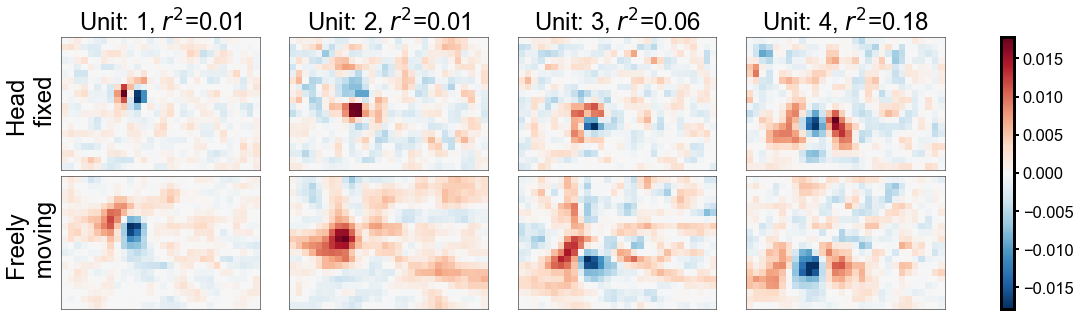

In [9]:

cells = [25,45,70,117] # 
# cells = [12,20,25] #[43,48,49,51,61,68,70,73,79,86,90,93,99] #np.arange(100)
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    crange1 = np.max(np.abs(sta_HF[cell]))
    im1 = axs1[0,n].imshow(sta_HF[cell], 'RdBu_r', vmin=-crange1, vmax=crange1)
    r2_up = np.corrcoef(sta_HF[cell].flatten(),sta_FM[cell].flatten())[0,1]**2
    axs1[0,n].set_title('Unit: {}, $r^2$={:.02f}'.format(n+1,r2_up), fontsize=fontsize)
    crange2 = np.max(np.abs(sta_FM[cell]))
    im2 = axs1[1,n].imshow(sta_FM[cell],'RdBu_r', vmin=-crange2, vmax=crange2)

axs1[0,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[1,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
# cbar2.set_ticks([-crange2, crange2])
# cbar2.set_ticklabels(['Dark', 'Light'])
# cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
# fig1.savefig(fig_dir/'HF_FM_RFComparison.png', facecolor='white', transparent=True, bbox_inches='tight')

In [113]:
sf = 4
FM_sta_up = np.zeros((GLM_VisMov_Vis['sta_all'].shape[0], GLM_VisMov_Vis['sta_all'].shape[1],sf*GLM_VisMov_Vis['sta_all'].shape[-2], sf*GLM_VisMov_Vis['sta_all'].shape[-1]))
HF_sta_up = np.zeros((GLM_VisMov_HF['sta_all'].shape[0], GLM_VisMov_HF['sta_all'].shape[1], sf*(GLM_VisMov_HF['sta_all'].shape[-2]), sf*(GLM_VisMov_HF['sta_all'].shape[-1])))
for n in range(GLM_VisMov_HF['sta_all'].shape[0]):
    for t in range(GLM_VisMov_HF['sta_all'].shape[1]):
        HF_sta_up[n, t] = cv2.resize(GLM_VisMov_HF['sta_all'][n, t], (sf*(GLM_VisMov_HF['sta_all'].shape[-1]), sf*(GLM_VisMov_HF['sta_all'].shape[-2])))
for n in range(GLM_VisMov_Vis['sta_all'].shape[0]):
    for t in range(GLM_VisMov_Vis['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_VisMov_Vis['sta_all'][n, t], (sf*GLM_VisMov_Vis['sta_all'].shape[-1], sf*GLM_VisMov_Vis['sta_all'].shape[-2]))


In [10]:
r2_HFFM_sta = np.zeros(model_nsp.shape[-1])
for celln in np.arange(model_nsp.shape[-1]):
    r2_HFFM_sta[celln] = np.corrcoef(sta_HF[celln].flatten(),sta_FM[celln].flatten())[0,1]

In [11]:
np.argmax(r2_HFFM_sta)

5

In [9]:
thresh_fr = 1
r2_thresh=.05
# r2_sigP = np.nanmean(r2_Mot,axis=0)

r2_sigV = np.nanmean(r2_Vis,axis=0)
r2_sig2 = (r2_sigV>r2_thresh) & (avg_fr>thresh_fr)
r2_idx = np.where(r2_sig2)[0]
np.sum(r2_sig2)

NameError: name 'r2_Vis' is not defined

(0.0, 0.25)

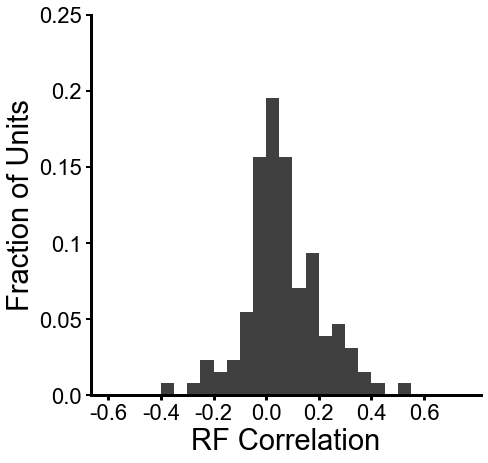

In [125]:

hbins=.05
fontsize=24
fig, ax = plt.subplots(figsize=(7,7))
count,edges = np.histogram(r2_HFFM_sta,bins=np.arange(-.6,.8,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(r2_HFFM_sta),color='k',width=hbins, alpha=.75)
ax.set_xlabel('RF Correlation',fontsize=fontsize+5)
ax.set_ylabel('Fraction of Units',fontsize=fontsize+5)
ax.set_yticks(np.arange(-.6,.8,.05))
ax.set_yticklabels(np.round(np.arange(-.6,.8,.05),decimals=3),fontsize=fontsize-2)
ax.set_xticks(np.arange(-.6,.8,.2))
ax.set_xticklabels(np.round(np.arange(-.6, .8, .2),decimals=1), fontsize=fontsize-2)
# ax.set_xlim(0,.8)
ax.set_ylim(0,.25)
# fig.savefig(fig_dir/'HFFM_RF_CCHist.pdf', facecolor='white', transparent=True, bbox_inches='tight')


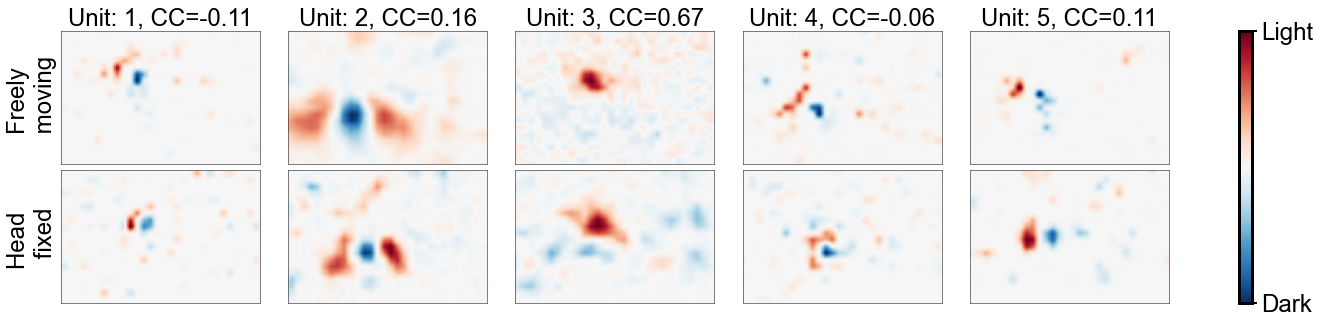

In [115]:

cells = [25,117,49,70,90] # 
# cells = np.arange(params['Ncells'])
# cells = [12,20,25,68] #np.arange(18)
# cells = [43,48,49,51,61,68,70,73,79,86,90,93,99] #np.arange(100)

num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk
xcut1=5
xcut2=-5
ycut1=5
ycut2=-5
# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    r2_up = np.corrcoef(sta_HF[cell,xcut1:xcut2,ycut1:ycut2].flatten(),sta_FM[cell,xcut1:xcut2,ycut1:ycut2].flatten())[0,1]
    crange2 = np.max(np.abs(FM_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im2 = axs1[0,n].imshow(FM_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    crange1 = np.max(np.abs(HF_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im1 = axs1[1,n].imshow(HF_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs1[0,n].set_title('Unit: {}, CC={:.02f}'.format(n+1,r2_up), fontsize=fontsize)

axs1[1,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange1, crange1])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
# fig1.savefig(fig_dir/'HF_FM_RF_CCComparison.png', facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
# cells = [25,70,90,117] # 49
cells = [12,20,25,68] #np.arange(18)
num_cells = len(cells)

fig1 = plt.figure(constrained_layout=False, figsize=(int(5*params['nt_glm_lag']),int(3*num_cells)))
spec2 = gridspec.GridSpec(ncols=params['nt_glm_lag'], nrows=num_cells, figure=fig1, wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(num_cells) for m in range(params['nt_glm_lag'])]).reshape(num_cells,params['nt_glm_lag'])
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up[cell]))
    for lag in range(params['nt_glm_lag']):
        im2 = axs1[n,lag].imshow(FM_sta_up[cell, lag],'RdBu_r', vmin=-crange2, vmax=crange2)
        axs1[0,lag].set_title('Lag:{:03d} ms'.format(int(1000*params['lag_list'][lag]*params['model_dt'])),fontsize=fontsize)
    axs1[n,0].set_ylabel('Unit {}'.format(n+1),fontsize=fontsize)
cbar2 = fig.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# fig1.savefig(fig_dir/'Example_FM_RFs.png', facecolor='white', transparent=True, bbox_inches='tight')
# print('Saved to: {}'.format(FigPath_SFN/'FM_RFs.png'))

In [117]:
GLM_VisMov_HF['r2_test'][r2_HFFM_sta>.09].shape[0],GLM_VisMov_HF['r2_test'].shape[0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 128

In [ ]:
fig, ax = plt.subplots()
im=ax.scatter(GLM_VisMov_HF['r2_test'][r2_HFFM_sta>.09],GLM_VisMov_Vis['r2_test'][r2_HFFM_sta>.09],c=r2_HFFM_sta[r2_HFFM_sta>.09],cmap='cool')
ax.set_xlabel('Head-Fixed $r^2$')
ax.set_ylabel('Free-Moving $r^2$')
cbar = add_colorbar(im)

In [116]:
##### Plot All Cells #####
cells = np.argpartition(r2_HFFM_sta, -127)[-127:]
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    r2_up = np.corrcoef(sta_HF[cell,xcut1:xcut2,ycut1:ycut2].flatten(),sta_FM[cell,xcut1:xcut2,ycut1:ycut2].flatten())[0,1]
    crange2 = np.max(np.abs(FM_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im2 = axs1[0,n].imshow(FM_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    crange1 = np.max(np.abs(HF_sta_up[cell,0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    im1 = axs1[1,n].imshow(HF_sta_up[cell, 0,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs1[0,n].set_title('Unit: {}, CC={:.02f}'.format(n+1,r2_up), fontsize=fontsize)

axs1[1,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])  
plt.tight_layout()  
plt.close()
fig1.savefig(params['fig_dir']/'HF_FM_RFComparison_sorted.pdf', facecolor='white', transparent=True, bbox_inches='tight')

/tmp/ipykernel_53744/3476419894.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [23]:
params['fig_dir']

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/070921/J553RT/fm1')

### HF predicts FM

In [ ]:
params['free_move']=False
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)

In [ ]:
Nepochs = 12000
Kfold = 0
GLM_VisMov_Vis = ioh5.load(save_dir_fm/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
w_FM = torch.from_numpy(GLM_VisMov_Vis['sta_all'].reshape(GLM_VisMov_Vis['sta_all'].shape[0],-1)).to(device)
w_HF = torch.from_numpy(GLM_VisMov_HF['sta_all'].reshape(GLM_VisMov_HF['sta_all'].shape[0],-1)).to(device)

In [ ]:

l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=None,reg_alphm=None,move_features=None,
                        meanfr=meanbias,init_sta=w_FM,
                        train_shifter=False,
                        LinMix=False,NonLinLayer=False, device=device,).to(device)


# GLM_Network = GLM_VisMov_HF
# key_list = ['sta_all','bias', 'w_move','biasm']

# param_dict = {}
# for (pname, param),key in zip(l1.named_parameters(),key_list):
#     if key == 'sta_all':
#         param_dict[pname] = torch.from_numpy(GLM_Network[key].reshape(data['model_nsp'].shape[-1],-1).astype(np.float32))
#     else: 
#         param_dict[pname] = torch.from_numpy(GLM_Network[key].astype(np.float32))
# l1.load_state_dict(param_dict)

In [ ]:
out = l1(xtr, xtrm,shift_in_tr)
loss = l1.loss(out, ytr)
pred = l1(xte, xtem,shift_in_te)
val_loss = l1.loss(pred, yte)
pred_test2 = pred.detach().cpu().numpy()

In [ ]:
celln = 25
bin_length=40
fig,ax = plt.subplots(figsize=(20,5))
GLM_Network = GLM_VisMov_HF # GLM_VisMov_Vis #
sp_smooth = ((np.convolve(GLM_Network['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth1 = ((np.convolve(GLM_Network['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# sp_smooth = (sp_smooth-np.nanmean(sp_smooth))/np.max(sp_smooth-np.nanmean(sp_smooth))
# pred_smooth_Vis = (pred_smooth_Vis-np.nanmean(pred_smooth_Vis))/np.max(pred_smooth_Vis-np.nanmean(pred_smooth_Vis))
# pred_smooth1 = (pred_smooth1-np.nanmean(pred_smooth1))/np.max(pred_smooth1-np.nanmean(pred_smooth1))


ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
ax.plot(np.arange(len(pred_smooth1))*params['model_dt'],pred_smooth1,'r', lw=3)
ax.plot(np.arange(len(pred_smooth2))*params['model_dt'],pred_smooth2,'g', lw=2)
r2_01 = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
r2_02 = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
r2_12 = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2
ax.set_title('$r^2 (01)$: {:.02f}, $r^2 (02)$: {:.02f}, $r^2 (12)$: {:.02f} '.format(r2_01,r2_02,r2_12))
ax.legend(['Actual (0)','Trained Weights: FM (1)', 'Used weights: HF (2)'], loc='upper left')
fig.savefig(fig_dir/'HFData_FMW_Cell{}.png'.format(celln), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
# FM Data HF Weights
r2_HM_FM2 = np.zeros((3,output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth1 = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_HM_FM2[0,celln] = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
    r2_HM_FM2[1,celln] = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
    r2_HM_FM2[2,celln] = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2

In [ ]:
r2_HM_FM = np.zeros((3,output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(GLM_VisMov_HF['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth1 = ((np.convolve(GLM_VisMov_HF['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_HM_FM[0,celln] = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
    r2_HM_FM[1,celln] = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
    r2_HM_FM[2,celln] = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2

In [ ]:
thresh = .09

inds = r2_HFFM_sta>thresh

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(r2_HM_FM[0,inds],r2_HM_FM[1,inds])
axs[0].set_xlabel('HF_W w/ HF_data $r^2$')
axs[0].set_ylabel('FM_W w/ HF_data $r^2$')
axs[0].set_ylim(-.05,.5)

axs[1].scatter(r2_HM_FM2[0,inds],r2_HM_FM2[1,inds])
axs[1].set_xlabel('FM_W w/ FM_data $r^2$')
axs[1].set_ylabel('HF_W w/ FM_data $r^2$')
axs[1].set_ylim(-.05,.5)
plt.tight_layout()
fig.savefig(fig_dir/'SwappingWeights.png', facecolor='white', transparent=True, bbox_inches='tight')

### Testing Gabors

In [ ]:

def gabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    # (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
    (y, x) = np.meshgrid(np.arange(-15, 15 + 1), np.arange(-10, 10 + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [ ]:
celln = 90
gb = gabor(2,5,10,2,1)
fig,axs = plt.subplots(2,1,figsize=(5,8))
axs[0].imshow(gb)
axs[1].imshow(sta_FM[celln])

# Position FR Plots

In [ ]:
GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 12000))
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))


In [ ]:
celln = 126
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']

fig, axs = plt.subplots(4,1,figsize=(20,20))
for modeln in np.arange(len(titles)):
    ax = axs[modeln]
    sp_smooth = ((np.convolve(GLM_VisMov_Add['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    ax.plot(np.arange(len(sp_smooth))*model_dt, (sp_smooth-np.mean(sp_smooth)) /np.max(sp_smooth-np.mean(sp_smooth)), 'k', lw=3, label='V1 Firing Rate')
    # ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,(pred_smooth_Vis-np.mean(pred_smooth_Vis))/np.max(pred_smooth_Vis),'g', lw=2,label='Vis')
    # ax.plot(np.arange(len(pred_smooth_Add))*model_dt,(pred_smooth_Add-np.mean(pred_smooth_Add))/np.max(pred_smooth_Add),'b', lw=2, label='Vis+Mov')
    # ax.plot(np.arange(len(pred_smooth_Mul))*model_dt,(pred_smooth_Mul-np.mean(pred_smooth_Mul))/np.max(pred_smooth_Mul),'r', lw=2, label='Vis*Mov')
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*model_dt, smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_xlabel('Time (s)')
    ax.set_yticks(np.arange(-1,2,1))
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0)


# HeadFixed Plots

In [ ]:

ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
fontsize = 24
MovModel=1
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
dataset_type = 'test'
stat_bins = 5

if dataset_type == 'train':
    predcell = GLM_VisMov_HF['pred_train'][:,celln]/model_dt
    nspcell = GLM_VisMov_HF['train_nsp'][:,celln]/model_dt
    nsp_raw = GLM_VisMov_HF['train_nsp'].copy()
    pred_raw = GLM_VisMov_HF['pred_train'].copy()
    move_data = move_train.copy()
else: 
    predcell = GLM_VisMov_HF['pred_test'][:,celln]/model_dt
    nspcell = GLM_VisMov_HF['test_nsp'][:,celln]/model_dt
    nsp_raw = GLM_VisMov_HF['test_nsp'].copy()
    pred_raw = GLM_VisMov_HF['pred_test'].copy()
    move_data = move_test.copy()
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5
for n, celln in enumerate(tqdm([21,25,49,51,61,88,117,121,126])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    # axs = np.array([fig2.add_subplot(spec2[0, :])])
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    axs2 = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    
    if MovModel != 0:
        crange = np.max(np.abs(GLM_VisMov_HF['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_VisMov_HF['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(nsp_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(GLM_VisMov_HF['tloss_trace_all'][celln])
    f2_ax7.plot(GLM_VisMov_HF['vloss_trace_all'][celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    
    # top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    # for i,modeln in enumerate(range(len(titles))):
    #     metric = move_data[:,modeln]
    #     nranges = np.quantile(metric,quartiles)
    #     stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
    #     edge_mids = np.quantile(metric,spk_percentile2)#
    #     # for m in range(len(nranges)-1):
    #     #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
    #     axs2[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

    #     axs2[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    #     axs2[modeln].set_xlim(-30,30)
    #     axs2[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
    #     axs2[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    #     axs2[modeln].set_title(titles[modeln],fontsize=fontsize)
#         axs2[modeln].set_yticks(np.arange(0,top_yaxs,10).astype(int))
        
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


# Shifter Training


## Save best shifter

In [90]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = False
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn' 
# args['date_ani'] = '110421/J569LT'# args['date_ani']
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=True
args['NoL1']=True
args['do_norm']=True
params,file_dict,_ = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:634: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Model: 1, move_features: None


In [86]:
save_dir_fm = params['save_dir_fm'] /'GLM_Network/MovModel1/version_0'
save_datafile = save_dir_fm/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
GLM_CV = ioh5.load(save_datafile)


23

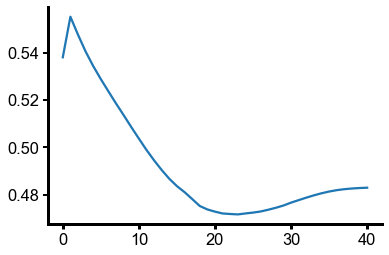

In [87]:
plt.plot(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))
best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))
best_shifter

In [91]:
##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_model_shift'].parent.parent.parent / fm_dir / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2],min=-20,max=20))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
shift_vid_file = params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1)
ioh5.save(shift_vid_file,model_vid_sm_shift2)
print(shift_vid_file)

/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/hf1_wn/ModelWC_shifted_dt050_MovModel1.h5


tensor([ 5.5714, -4.3311, -7.7958], grad_fn=<SelectBackward>)


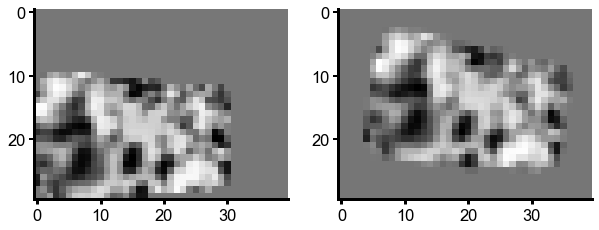

In [92]:
t = 1000
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(data['model_vid_sm'][t], cmap='gray')
axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
print(shift_out[t])

In [ ]:
best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))
Best_RF={}
for name, p in l1.named_parameters():
    if 'shifter' not in name:
        Best_RF[name] = torch.from_numpy(GLM_Data[name])
# best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
# torch.save({'model_state_dict': Best_RF}, (params['save_dir'] / best_shift))


In [31]:
save_datafile = params['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
GLM_Data = ioh5.load(save_datafile)

In [28]:
best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000,Kfold)
checkpoint = torch.load(params['save_dir']/best_shift)


(-0.5, 39.5, 29.5, -0.5)

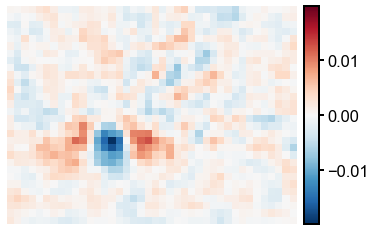

In [34]:
sta_all =checkpoint['model_state_dict']['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks']).cpu().detach().numpy()
celln = 117
fig,ax = plt.subplots()
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

## Training shifter

In [ ]:
# params['alphas_m'] = np.array([2])
a = 0
Nepochs=12000
nlam=1; nalph=1
track_all=True
# params['lr_m'] = [1e-2, 1e-2]
# params['lr_b'] = [1e-2, 1e-2]
# params['lr_g'] = [1e-2, 1e-2]

# params['lr_w'] = [1e-2, 1e-3]
params['alphas'] = np.array([0])
# params['nalph'] = len(params['alphas'])
# params['LinMix'] = False
params['lambdas'] = np.logspace(-3, 5, 40)[23:24]
params['nlam'] = len(params['lambdas'])
# params['lambdas_m'] = np.array(nlam*[0])
# params['lambdas_m'] = np.hstack((np.logspace(-3, 5, 10)[0], np.logspace(-3, 5, 20)))
# params['NonLinLayer'] = False

GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size))
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
GLM_CV['tloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['vloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['r2_test']         = np.zeros((params['nalph'], params['nlam'], output_size))

for a, reg_alph in enumerate(tqdm(params['alphas'],leave=True)):
    if params['MovModel'] == 1:
        pbar = tqdm(params['lambdas'])
    elif (params['MovModel'] != 1):
        pbar = tqdm(params['lambdas_m'])
    
    for l, reg_lam in enumerate(pbar):
        l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, l, a, params)
        if (a==0) & (l==0):
            for name, p in l1.named_parameters():
                GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
        elif (l!=0) & (params['MovModel']==1):
            l1.load_state_dict(state_dict)

        vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None,track_all=track_all)
        model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{}.pth'.format(model_type, params['WC_type'], int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'], a, l, Kfold)

        for name, p in l1.named_parameters():
            GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()

        if (l == 0) & (params['MovModel']==1):
            state_dict = l1.state_dict()

        GLM_CV['tloss_trace_all'][a, l] = tloss_trace.T
        GLM_CV['vloss_trace_all'][a, l] = vloss_trace.T
        
        pred = l1(xte, xtem, shift_in_te)
        GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
        GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
        out = l1(xtr, xtrm, shift_in_tr)
        GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T

malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    if 'shifter' in key:
        GLM_Data[key] = GLM_CV[key][malph,mlam]    
    else:
        GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]
            
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][malph,mlam,cellnum])[:,params['bin_length']:-params['bin_length']].T
GLM_Data['r2_test']= np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])


In [ ]:
hftofm_imu_file = '/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/110521_J569LT_control_Rig2_hf_to_fm_transfer_imu.nc'
imu_data = xr.open_dataset(hftofm_imu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
medfiltbins = 11
groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)
eye_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn/070921_J553RT_control_Rig2_hf1_wn_REYE.nc'
eye_data = xr.open_dataset(eye_file)

eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)


In [ ]:
plt.plot(groll[100:6000])
np.mean(groll[100:6000]),np.mean(gpitch[100:6000])

PosixPath('/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/110421/J569LT/fm1')

In [56]:
fmimu_file = list((params['data_dir'].parent / stim_type).glob('*imu.nc'))[0]
imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / args['date_ani'] / stim_type).glob('*REYE.nc'))[0]
eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
# fm_eye = {'avg_th': np.nanmean(th),'avg_phi': np.nanmean(phi)}
# ioh5.save(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(params['model_dt']*1000)),fm_eye)
FM_move_avg = np.zeros((2,3))
FM_move_avg[:,0] = np.array([np.nanmean(th),np.nanstd(th)])
FM_move_avg[:,1] = np.array([np.nanmean(phi),np.nanstd(phi)])
FM_move_avg[:,2] = np.array([np.nanmean(gpitch),np.nanstd(gpitch)])

# fm_eye= np.array([np.nanmean(th),np.nanmean(phi),np.nanstd(th),np.nanstd(phi)])
np.save(params['save_dir']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)),FM_move_avg)

In [57]:
FM_move_avg

array([[ 21.27710626, -33.49594415, -15.15282194],
       [ 13.59771177,  11.4845708 ,  14.19502535]])

In [25]:
avgfm_eye = np.load(params['save_dir_fm']/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))

## Plot shift matricies

In [10]:
reg_alph=a=0; l=7
l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        meanfr=meanbias,init_sta=sta_init,
                        train_shifter=params['train_shifter'],
                        NonLinLayer=False,
                        LinMix=False, device=device,)

l1.weight.shape,sta_init.shape

(torch.Size([128, 1200]), torch.Size([128, 1200]))

In [84]:
params['nlam']

41

In [81]:
reg_alph=a=0; l=23
GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size))
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
for l in np.arange(params['nlam']):
    l1 = LinVisNetwork(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        train_shifter=params['train_shifter'],
                        LinMix=params['LinMix'], device=device,).to(device)
    model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,a,l,Kfold)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
    checkpoint = torch.load(params['save_model_shift']/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])
    if (a==0) & (l==0):
        for name, p in l1.named_parameters():
            GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
    for name, p in l1.named_parameters():
        GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()
    pred = l1(xte, xtem, shift_in_te)
    GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm, shift_in_tr)
    GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T
malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    if 'shifter' in key:
        GLM_Data[key] = GLM_CV[key][malph,mlam]  
        # GLM_Data[key] = GLM_CV[key][0,23]
    else:
        GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]
        # GLM_Data[key] = GLM_CV[key][0,23,:]
GLM_Data['loss_regcv'] = GLM_CV['loss_regcv']
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][malph,mlam,cellnum])[:,params['bin_length']:-params['bin_length']].T
# pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][0,23,:])[:,params['bin_length']:-params['bin_length']].T
GLM_Data['r2_test']= np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
save_datafile = params['save_dir']/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
ioh5.save(save_datafile, GLM_Data)

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [85]:
ioh5.save(save_datafile, GLM_Data)

In [75]:
save_datafile.as_posix(),'/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLM_Network/MovModel1/version_0/GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5'


('/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLM_Network/MovModel1/version_0/GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5',
 '/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLM_Network/MovModel1/version_0/GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5')

In [165]:
    l1 = LinVisNetwork(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        train_shifter=False,
                        LinMix=params['LinMix'], device=device,).to(device)
    best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,Kfold)
    checkpoint = torch.load(params['save_dir']/best_shift)
    l1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
a=0;l = 23
l1 = LinVisNetwork(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        train_shifter=params['train_shifter'],
                        LinMix=params['LinMix'], device=device,).to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
checkpoint = torch.load(params['save_model_shift']/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])
shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift_out[:,-1] = torch.clamp(shift_out[:,-1],min=-45,max=45)
shift_out[:,:2] = torch.clamp(shift_out[:,:2],min=-20,max=20)
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()



NameError: name 'shifter_nn' is not defined

In [18]:
GLM_CV.keys(),GLM_CV['loss_regcv'][0,23]

(dict_keys(['loss_regcv', 'pred_cv', 'out_cv', 'Cell_NN.0.weight', 'Cell_NN.0.bias', 'shifter_nn.0.weight', 'shifter_nn.0.bias', 'shifter_nn.2.weight', 'shifter_nn.2.bias']),
 array([0.01490001, 0.22476822, 0.20099442, 0.1232269 , 0.07032989,
        1.1830678 , 0.46697938, 0.01842896, 0.15261985, 0.21664838,
        1.82159984, 0.17142405, 0.40097994, 0.05008464, 1.35177672,
        0.25197524, 0.06718076, 0.11226115, 0.06855693, 0.05170289,
        0.72786736, 0.03934126, 0.72407669, 0.10154002, 0.10835185,
        0.32839301, 0.22154023, 3.37879705, 0.61679995, 0.22966893,
        0.04336037, 0.20294774, 0.06553654, 0.04012547, 0.01790616,
        0.08630051, 0.02052019, 1.42054212, 0.05763952, 0.20381977,
        0.03881846, 2.9699626 , 0.20475163, 0.0494709 , 0.33921218,
        0.3123962 , 0.30329746, 0.64575934, 0.58218658, 0.51263076,
        0.64886165, 0.84021074, 0.04809829, 0.36962897, 0.97826278,
        0.56570882, 0.44331375, 0.04234741, 0.12700595, 0.06522023,
        1

0.25145748644029225

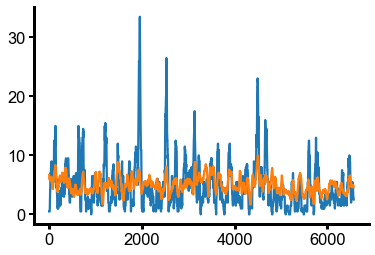

In [68]:
celln = 12
plt.plot(sp_smooth[:,celln])
plt.plot(pred_smooth[:,celln])
GLM_Data['r2_test'][celln]

tensor([-6.6665,  7.1210,  9.4333], grad_fn=<SelectBackward>)


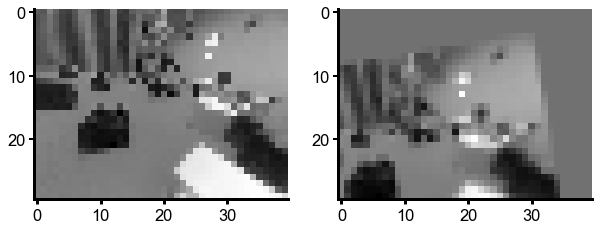

In [69]:
t = 210
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(data['model_vid_sm'][t], cmap='gray')
axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
print(shift_out[t])

22

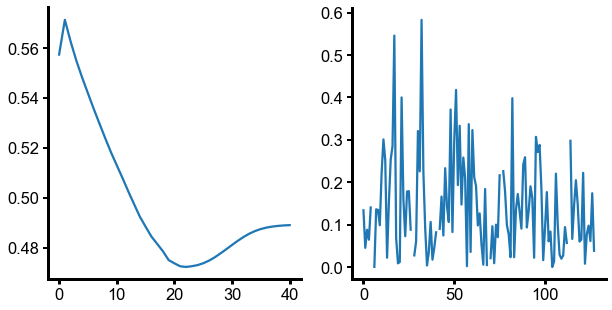

In [70]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(np.nanmean(GLM_Data['loss_regcv'][0,:],axis=-1))
axs[1].plot(GLM_Data['r2_test'])

np.nanargmin(np.nanmean(GLM_Data['loss_regcv'][0,:],axis=-1))


In [ ]:
best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,Kfold)
GLM_shift = ioh5.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_VisShifter_NoL1_VisMov_dt050_T01_MovModel1_NB5000_Kfold00.h5')

(-0.5, 39.5, 29.5, -0.5)

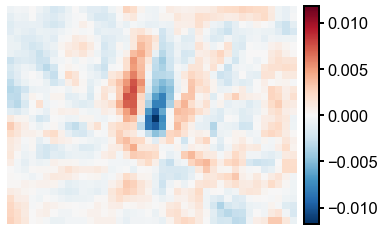

In [22]:
sta_all = GLM_Data['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])
celln = 12
fig,ax = plt.subplots()
crange = np.max(np.abs(sta_all[celln,0]))
im = ax.imshow(sta_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')

In [39]:
Best_RF.keys(),Best_RF['Cell_NN.0.weight'].shape

(dict_keys(['Cell_NN.0.weight', 'Cell_NN.0.bias']), torch.Size([71, 1200]))

In [42]:
best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000,Kfold)

checkpoint = torch.load('/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1/GLM_Pytorch_BestShift_dt050_T01_MovModel1_NB5000_Kfold0.pth')

In [43]:
checkpoint['model_state_dict']['Cell_NN.0.weight'].shape

torch.Size([71, 1200])

In [49]:
hidden_size=128
output_size=71
l1 = VisNetwork(input_size, hidden_size, output_size, 
                reg_alph=0, reg_alph2=0,
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)

In [51]:
l1

VisNetwork(
  (Cell_NN): Sequential(
    (0): Linear(in_features=1200, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=71, bias=True)
  )
  (activations): ModuleDict(
    (SoftPlus): Softplus(beta=1, threshold=20)
    (ReLU): ReLU()
  )
)

In [32]:
a = 0 
best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))
Best_RF={}
for name, p in l1.named_parameters():
    if 'shifter' not in name:
        Best_RF[name] = torch.from_numpy(GLM_Data[name])
best_shift = 'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:01d}.pth'.format('Pytorch_BestShift',int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
torch.save({'model_state_dict': Best_RF}, (params['save_dir'] / best_shift))
# save_model2 = save_model/'Shifter'
model_vid_sm_shift2 = {}
pdf_name = params['fig_dir']/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary.pdf'.format('Pytorch_VisMov_AddMul_NoL1_Shifter',int(params['model_dt']*1000),params['nt_glm_lag'], params['MovModel'])
with PdfPages(pdf_name) as pdf:
    for l,lam in enumerate(tqdm(params['lambdas'])):
        model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],a,l,Kfold)
        # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
        checkpoint = torch.load(params['save_model_shift']/model_name)
        l1.load_state_dict(checkpoint['model_state_dict'])
        l1.cpu()
        # ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
        ##### Sweep -3 to 3 standard deviations 
        ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-3,3,81),np.linspace(-3,3,81),np.linspace(-3,3,81),sparse=False,indexing='ij')

        shift_mat = np.zeros((3,) + ang_sweepx.shape)
        for i in range(ang_sweepx.shape[0]):
            for j in range(ang_sweepy.shape[1]):
                ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
                shift_vec = l1.shifter_nn(ang_sweep).detach().cpu().numpy()
                shift_mat[0,i,j] = shift_vec[:,0]
                shift_mat[1,i,j] = shift_vec[:,1]
                shift_mat[2,i,j] = shift_vec[:,2]

            
        fig, ax = plt.subplots(1,4,figsize=(20,5))
        crange = np.max(np.abs(shift_mat[:2]))
        im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar1 = add_colorbar(im1)
        ax[0].set_xticks(np.arange(0,90,20))
        ax[0].set_xticklabels(np.arange(-40,50,20))
        ax[0].set_yticks(np.arange(0,90,20))
        ax[0].set_yticklabels(np.arange(-40,50,20))
        ax[0].set_xlabel('Theta')
        ax[0].set_ylabel('Phi')
        ax[0].set_title('Horizontal Shift')


        im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar2 = add_colorbar(im2)
        ax[1].set_xticks(np.arange(0,90,20))
        ax[1].set_xticklabels(np.arange(-40,50,20))
        ax[1].set_yticks(np.arange(0,90,20))
        ax[1].set_yticklabels(np.arange(-40,50,20))
        ax[1].set_xlabel('Theta')
        ax[1].set_ylabel('Phi')
        ax[1].set_title('Vertical Shift')

        crange = np.max(np.abs(shift_mat[2]))
        im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar3 = add_colorbar(im3)
        ax[2].set_xticks(np.arange(0,90,20))
        ax[2].set_xticklabels(np.arange(-40,50,20))
        ax[2].set_yticks(np.arange(0,90,20))
        ax[2].set_yticklabels(np.arange(-40,50,20))
        ax[2].set_xlabel('Theta')
        ax[2].set_ylabel('Pitch')
        ax[2].set_title('Rotational: Phi=0')

        im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar4 = add_colorbar(im4)
        ax[3].set_xticks(np.arange(0,90,20))
        ax[3].set_xticklabels(np.arange(-40,50,20))
        ax[3].set_yticks(np.arange(0,90,20))
        ax[3].set_yticklabels(np.arange(-40,50,20))
        ax[3].set_xlabel('Phi')
        ax[3].set_ylabel('Pitch')
        ax[3].set_title('Rotational: Theta=0')
        plt.tight_layout()

        pdf.savefig()
        plt.close()

model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],a,best_shifter,Kfold)
checkpoint = torch.load(params['save_model_shift']/model_name)
l1.load_state_dict(checkpoint['model_state_dict'])
l1.cpu()
shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
model_vid_sm_shift = shift(torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))).detach().cpu().numpy().squeeze()

model_vid_sm_shift2['model_vid_sm_shift'] = model_vid_sm_shift
ioh5.save(params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), params['MovModel']),model_vid_sm_shift2)


  0%|          | 0/41 [00:00<?, ?it/s]

In [11]:
save_datafile = params['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,Kfold)
GLM_Shifter = ioh5.load(save_datafile)

In [12]:
GLM_Shifter['loss_regcv'].shape

(71,)

In [10]:
plt.plot(np.nanmean(GLM_Shifter['loss_regcv'][0,:],axis=-1))
# plt.plot(GLM_Shifter['loss_regcv'][0,:,45])

np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0,:],axis=-1))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [20]:
shift_dir = Path('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models/Shifter/')

In [51]:
'GLM_Pytorch_VisShifter_NoL1_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam23_Kfold0.pth',model_name

('GLM_Pytorch_VisShifter_NoL1_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam23_Kfold0.pth',
 'GLM_Pytorch_VisShifter_NoL1_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam0_Kfold0.pth')

In [42]:
save_model_fm

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models/Shifter')

In [53]:
##### Load single shifter network and shift videos #####
reg_alph=a=0; l=23
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
# avgfm_eye = np.load(save_dir/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
# save_model_fm = save_model.parent.parent.parent / fm_dir / 'models/Shifter'
# model_move = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis], data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
# model_move = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis], 
#                         np.zeros(data['model_th'].shape)[:,np.newaxis],np.zeros(data['model_th'].shape)[:,np.newaxis]))
                        # (np.mean(groll[100:6000])*np.ones(model_th.shape))[:, np.newaxis], (np.mean(gpitch[100:6000])*np.ones(model_th.shape))[:, np.newaxis]))
shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(params['save_model_shift']/model_name)
# checkpoint = torch.load(shift_dir/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2],min=-20,max=20))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
# model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
# ioh5.save(params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1),model_vid_sm_shift2)


In [55]:
params['save_dir']

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/110421/J569LT/fm1')

tensor([ 6.5559, -4.6979,  7.3675], grad_fn=<SelectBackward>)


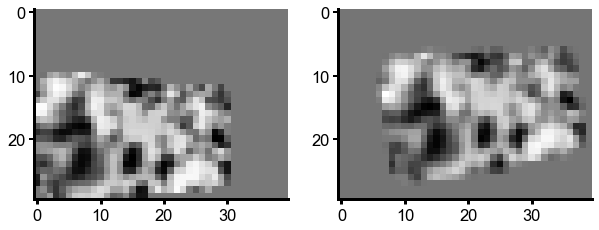

In [54]:
t = 1000
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(data['model_vid_sm'][t], cmap='gray')
axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
print(shift_out[t])

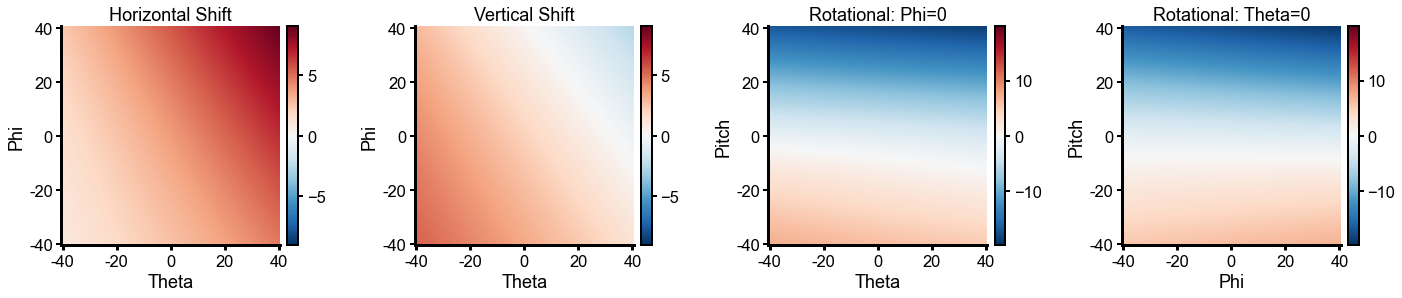

In [100]:
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-3,3,81),np.linspace(-3,3,81),np.linspace(-3,3,81),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)

    
fig, ax = plt.subplots(1,4,figsize=(20,5))
crange = np.max(np.abs(shift_mat[:2]))
im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
ax[0].set_xticks(np.arange(0,90,20))
ax[0].set_xticklabels(np.arange(-40,50,20))
ax[0].set_yticks(np.arange(0,90,20))
ax[0].set_yticklabels(np.arange(-40,50,20))
ax[0].set_xlabel('Theta')
ax[0].set_ylabel('Phi')
ax[0].set_title('Horizontal Shift')


im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar2 = add_colorbar(im2)
ax[1].set_xticks(np.arange(0,90,20))
ax[1].set_xticklabels(np.arange(-40,50,20))
ax[1].set_yticks(np.arange(0,90,20))
ax[1].set_yticklabels(np.arange(-40,50,20))
ax[1].set_xlabel('Theta')
ax[1].set_ylabel('Phi')
ax[1].set_title('Vertical Shift')

crange = np.max(np.abs(shift_mat[2]))
im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar3 = add_colorbar(im3)
ax[2].set_xticks(np.arange(0,90,20))
ax[2].set_xticklabels(np.arange(-40,50,20))
ax[2].set_yticks(np.arange(0,90,20))
ax[2].set_yticklabels(np.arange(-40,50,20))
ax[2].set_xlabel('Theta')
ax[2].set_ylabel('Pitch')
ax[2].set_title('Rotational: Phi=0')

im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
cbar4 = add_colorbar(im4)
ax[3].set_xticks(np.arange(0,90,20))
ax[3].set_xticklabels(np.arange(-40,50,20))
ax[3].set_yticks(np.arange(0,90,20))
ax[3].set_yticklabels(np.arange(-40,50,20))
ax[3].set_xlabel('Phi')
ax[3].set_ylabel('Pitch')
ax[3].set_title('Rotational: Theta=0')
plt.tight_layout()

In [ ]:

shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-30,max=30),translation=torch.clamp(shift_out[:,:2],min=-15,max=15))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()


In [ ]:
move_model2 = np.stack([model_move[np.all((model_move>move_quantiles[0]) & (model_move<move_quantiles[1]),axis=1),modeln] for modeln in range(4)])

In [ ]:
clrs = ['blue','orange','green','red']

for modeln in [0,1,3]:
    plt.hist(model_move[:,modeln],color=clrs[modeln],bins=100,alpha=.6)
    plt.axvline(x=move_quantiles[0,modeln],c=clrs[modeln])
    plt.axvline(x=move_quantiles[1,modeln],c=clrs[modeln])

In [ ]:
sta = l1.weight.clone().detach().cpu().numpy().reshape((output_size,1) + nks)
# sta_grid = vutils.make_grid(sta[:,:,:,:],nrow=10,normalize=True,scale_each=True)

nrows = (output_size//10)+1
ncols = 10
fig, axs = plt.subplots(nrows,ncols, figsize=(40,40))
axs = axs.flatten()
for celln in tqdm(np.arange(output_size)):
    ax = axs[celln]
    crange = np.nanmax(np.abs(sta[celln]))
    im = ax.imshow(sta[celln,0], cmap='RdBu_r', vmin=-crange, vmax=crange)
    ax.axis('off')
    cbar = add_colorbar(im)
plt.tight_layout()

In [ ]:
model_vid_sm_shift

In [ ]:
modeln = 1
t=0
dt=1000
mv_data = model_move[t:t+dt,modeln]
mv_data = mv_data - np.mean(mv_data)
mv_data = mv_data/np.max(mv_data)
sft_data = shift_out.cpu().detach().numpy()[t:t+dt,modeln]
sft_data = sft_data - np.mean(sft_data)
sft_data = sft_data/np.max(sft_data)
plt.plot(mv_data)
plt.plot(sft_data)

In [ ]:
np.save(file=(save_dir / 'Shifted_worldcam_dt{:03d}.npy'.format(int(.025*1000))), arr=model_vid_sm_shift)

In [ ]:
l=8
model_vid_sm_shift = model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] 

In [ ]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Uncorrected, Frame={}'.format(t))
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Corrected, Frame={}'.format(t))
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [ ]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(10000)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = date_ani2+ '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


In [ ]:

##### Make video with opencv #####
aniname = date_ani2 + '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()

In [ ]:
GLM_VisMov_Shift = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis_NoL1', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000, Kfold))
locals().update(GLM_VisMov_Shift)

In [ ]:

celln = 49 # np.argmax(r2_test)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([12,13,20,25,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, :])])
    # axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :5//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (5//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_test[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*params['model_dt'],pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[celln])
    f2_ax7.plot(vloss_trace_all[celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [ ]:
model_vid_sm_shift2 = {}
for l in range(11,21):
    model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,a,l,Kfold)
    checkpoint = torch.load(save_model2/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])

    ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
    shift_mat = np.zeros((3,) + ang_sweepx.shape)
    for i in range(ang_sweepx.shape[0]):
        for j in range(ang_sweepy.shape[1]):
            ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T).to(device)
            shift_vec = l1.shifter_nn(ang_sweep).detach().cpu().numpy()
            shift_mat[0,i,j] = shift_vec[:,0]
            shift_mat[1,i,j] = shift_vec[:,1]
            shift_mat[2,i,j] = shift_vec[:,2]

        
    fig, ax = plt.subplots(2,2,figsize=(10,8))
    ax = ax.flatten()
    crange = np.max(np.abs(shift_mat[:2]))
    im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[0].set_xticks(np.arange(0,90,20))
    ax[0].set_xticklabels(np.arange(-40,50,20))
    ax[0].set_yticks(np.arange(0,90,20))
    ax[0].set_yticklabels(np.arange(-40,50,20))
    ax[0].set_xlabel('Theta')
    ax[0].set_ylabel('Phi')
    ax[0].set_title('Horizontal Shift')


    im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar2 = add_colorbar(im2)
    ax[1].set_xticks(np.arange(0,90,20))
    ax[1].set_xticklabels(np.arange(-40,50,20))
    ax[1].set_yticks(np.arange(0,90,20))
    ax[1].set_yticklabels(np.arange(-40,50,20))
    ax[1].set_xlabel('Theta')
    ax[1].set_ylabel('Phi')
    ax[1].set_title('Vertical Shift')

    crange = np.max(np.abs(shift_mat[2]))
    im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar3 = add_colorbar(im3)
    ax[2].set_xticks(np.arange(0,90,20))
    ax[2].set_xticklabels(np.arange(-40,50,20))
    ax[2].set_yticks(np.arange(0,90,20))
    ax[2].set_yticklabels(np.arange(-40,50,20))
    ax[2].set_xlabel('Theta')
    ax[2].set_ylabel('Pitch')
    ax[2].set_title('Rotational: Phi=0')

    im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar4 = add_colorbar(im4)
    ax[3].set_xticks(np.arange(0,90,20))
    ax[3].set_xticklabels(np.arange(-40,50,20))
    ax[3].set_yticks(np.arange(0,90,20))
    ax[3].set_yticklabels(np.arange(-40,50,20))
    ax[3].set_xlabel('Phi')
    ax[3].set_ylabel('Pitch')
    ax[3].set_title('Rotational: Theta=0')
    plt.tight_layout()
    # fig.savefig(fig_dir/'ThetaPhiPitch_Shifter_lam{}.pdf'.format(l), facecolor='white', transparent=True, bbox_inches='tight')

    # shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
    # shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
    # model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

    # model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
# ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), MovModel),model_vid_sm_shift2)

In [8]:
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), 1, 1, 12000,Kfold))


In [9]:
np.nanargmin(GLM_VisMov_Vis['loss_regcv'],axis=1)

array([[19, 27, 26, 22, 26, 25, 27, 40, 27, 23, 22, 18, 20, 40, 24, 27,
        28, 27, 25, 31, 22, 22, 40, 28, 19, 23, 26, 26, 25, 29, 27, 40,
        24, 38, 28, 28, 37, 22, 28, 22, 40, 29, 17, 40, 25, 26, 23, 30,
        23, 23, 25, 26,  6, 27, 26, 25, 26, 40, 40, 17, 22, 24, 22, 31,
        24, 28, 26, 40, 17, 40, 40]])

In [7]:
GLM_VisMov_Vis['sta_all'].shape

(4, 1, 30, 40)

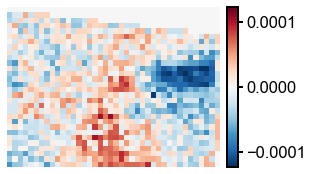

In [11]:
celln = 1
fig,ax = plt.subplots(1,params['nt_glm_lag'],figsize=(5,5))
crange = np.max(np.abs(GLM_VisMov_Vis['sta_all'][celln]))
# for m,ax in enumerate(axs):
im = ax.imshow(GLM_VisMov_Vis['sta_all'][celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')
plt.tight_layout()

# Raster Plots

In [ ]:

ephys_file = save_dir/'RawEphysData.h5'
ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']
Tmax = 5
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>0) &(spks < Tmax)])


In [ ]:
fontsize=24
fig,axs = plt.subplots(figsize=(5,5))
ax = axs
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('Time (sec)',fontsize=fontsize+5)
ax.set_ylabel('Cell #',fontsize=fontsize+5)
ax.set_yticks(np.arange(0,params['Ncells'],2))
ax.set_yticklabels(np.arange(0, params['Ncells'], 2),fontsize=fontsize)
ax.set_xticks(np.arange(0, 6, 2))
ax.set_xticklabels(np.arange(0, 6, 2), fontsize=fontsize)

plt.show()
fig.savefig(fig_dir/'SpikeRaster.pdf', facecolor='white', transparent=True, bbox_inches='tight')


# WorldCam/EyeCam/IMU Example

In [ ]:
celln = 12
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']
fontsize=24
fig, axs = plt.subplots(4,1,figsize=(10,5),sharex=True)
for modeln,ax in enumerate(axs):
    sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*params['model_dt'], smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_yticks([])
axs[-1].tick_params(axis='x', labelsize=fontsize)
axs[-1].set_xlabel('Time (sec)',fontsize=fontsize)
fig.savefig(fig_dir/'IMU_Example.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [2]:
WC_raw = np.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/uncorrected_worldcam_dt050.npy')

In [6]:
WC_raw.shape,data['model_vid_sm'].shape

((146765, 120, 160), (22326, 30, 40))

In [ ]:
fig,axs = plt.subplots(1,figsize=(2,2))
# axs.imshow(WC_raw[1000], cmap='gray')
axs.imshow(model_vid_sm_shift[2000], cmap='gray')
axs.axis('off')
fig.savefig(fig_dir/'WC_DSIm.pdf', facecolor='white', transparent=True, bbox_inches='tight')

# axs[1].imshow(model_vid_sm_shift[1000])

# Position Only

In [ ]:
params['nt_glm_lag']

In [ ]:
'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold)

In [ ]:
celln = 101
bin_length=40
Nepochs = 5000
fontsize = 24
for Kfold in range(3):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold))
    GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))
    GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))

    fig,ax = plt.subplots(figsize=(20,5))
    sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Mot = ((np.convolve(GLM_VisMov_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2,label='Actual')
    ax.plot(np.arange(len(pred_smooth_Mot))*params['model_dt'],pred_smooth_Mot,'r', lw=2,label='Mot')
    ax.plot(np.arange(len(pred_smooth_Vis))*params['model_dt'],pred_smooth_Vis,'b', lw=2,label='Vis')
    ax.plot(np.arange(len(pred_smooth_Add))*params['model_dt'],pred_smooth_Add,'m', lw=2,label='Add')
    ax.plot(np.arange(len(pred_smooth_Mul))*params['model_dt'],pred_smooth_Mul,'g', lw=2,label='Mul')
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
    ax.set_xlabel('Time (s)',fontsize=fontsize)
    ax.set_ylabel('Spike Rate',fontsize=fontsize)
    r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
    r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
    r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
    r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
    ax.set_title('Kfold:{:02d}, Mot:{:.03}, Vis:{:.03}, Add:{:.03}, Mul:{:.03}'.format(Kfold, r2_Mot,r2_Vis,r2_Add,r2_Mul))
    fig.savefig(fig_dir/'ExamplePredFR_celln{}_Kfold{:02d}.png'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
Kfold = 2
Nepochs=5000
bin_length = 40
move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 5000, Kfold))
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))


In [ ]:

celln = 101
t = 1200
dt = 2000
fontsize=24
fig,ax = plt.subplots(figsize=(15,5))
sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

pred_smooth_Mot = ((np.convolve(GLM_VisMov_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2

ax.plot(np.arange(len(sp_smooth[t:t+dt]))*params['model_dt'],sp_smooth[t:t+dt], 'k', lw=5,label='Actual', zorder=0)
ax.plot(np.arange(len(pred_smooth_Mot[t:t+dt]))*params['model_dt'],pred_smooth_Mot[t:t+dt],'r', lw=5,label='Pos: $r^2$={:.02f}'.format(r2_Mot), zorder=4)
ax.plot(np.arange(len(pred_smooth_Vis[t:t+dt]))*params['model_dt'],pred_smooth_Vis[t:t+dt],'b', lw=5,label='Vis: $r^2$={:.02f}'.format(r2_Vis), zorder=3)
ax.plot(np.arange(len(pred_smooth_Add[t:t+dt]))*params['model_dt'],pred_smooth_Add[t:t+dt],'m', lw=5,label='Add: $r^2$={:.02f}'.format(r2_Add), zorder=2)
ax.plot(np.arange(len(pred_smooth_Mul[t:t+dt]))*params['model_dt'],pred_smooth_Mul[t:t+dt],'g', lw=5,label='Mul: $r^2$={:.02f}'.format(r2_Mul), zorder=1)
ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True, bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

fig.savefig(fig_dir/'Mul_ExamplePredFR_celln{}_Kfold{:02d}.pdf'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')

# Cell Type

In [19]:
import pickle

In [4]:
Nepochs = 5000
params['NKfold']=2
r2_Mot = np.zeros((params['NKfold'],output_size))
r2_Vis = np.zeros((params['NKfold'],output_size))
r2_Add = np.zeros((params['NKfold'],output_size))
r2_Mul = np.zeros((params['NKfold'],output_size))
r2_AddMul = np.zeros((params['NKfold'],output_size))
for Kfold in range(params['NKfold']):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    # GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs,Kfold))
    GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    # GLM_VisMov_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))
    # r2_Mot[Kfold] = GLM_VisMov_Mot['r2_test'].copy()
    r2_Vis[Kfold] = GLM_VisMov_Vis['r2_test'].copy()
    r2_Add[Kfold] = GLM_VisMov_Add['r2_test'].copy()
    r2_Mul[Kfold] = GLM_VisMov_Mul['r2_test'].copy()
    # r2_AddMul[Kfold] = GLM_VisMov_AddMul['r2_test'].copy()

Done Loading Unaligned data


NameError: name 'save_dir' is not defined

In [23]:
celltype['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070621_J553LT_control_Rig2',
       '070921_J553RT_control_Rig2', '090821_HGeM1LT_control_Rig2',
       '101521_J559NC_control_Rig2', '102121_J570NC_control_Rig2',
       '102621_J558NC_control_Rig2', '102821_J570LT_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2'],
      dtype=object)

In [22]:
celltype_dir = params_m1['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))
celltype2 = celltype[celltype['session']==celltype['session'].unique()[2]].reset_index(drop=True)

In [21]:
inh = celltype2['exc_or_inh'] == 'inh'
exc = celltype2['exc_or_inh'] == 'exc'
depth = celltype2['hf1_wn_depth_from_layer5']

In [90]:
np.where(~pd.isna((celltype['early_comp_responsive'])))

(array([ 13,  15,  18,  19,  20,  21,  23,  24,  25,  27,  51,  55,  67,
         69,  74,  78,  85,  89,  98, 112, 115, 119]),)

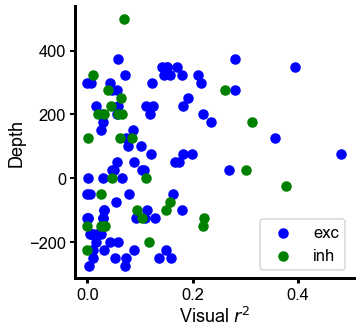

In [91]:
fig, axs = plt.subplots(1,figsize=(5,5))
ax = axs
ax.scatter(GLM_VisMov_Vis['r2_test'][exc],celltype['hf1_wn_depth_from_layer5'][exc],c='b',label='exc')
ax.scatter(GLM_VisMov_Vis['r2_test'][inh],celltype['hf1_wn_depth_from_layer5'][inh],c='g',label='inh')

ax.set_xlabel('Visual $r^2$')
ax.set_ylabel('Depth')
ax.legend(loc='lower right')


/tmp/ipykernel_578284/416108227.py:6: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
/tmp/ipykernel_578284/416108227.py:7: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
/tmp/ipykernel_578284/416108227.py:8: RuntimeWarning: Mean of empty slice
  yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]
/tmp/ipykernel_578284/416108227.py:30: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
/tmp/ipykernel_578284/416108227.py:31: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
/tmp/ipykernel_578284/416108227.py:48: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Add,axis=0) -

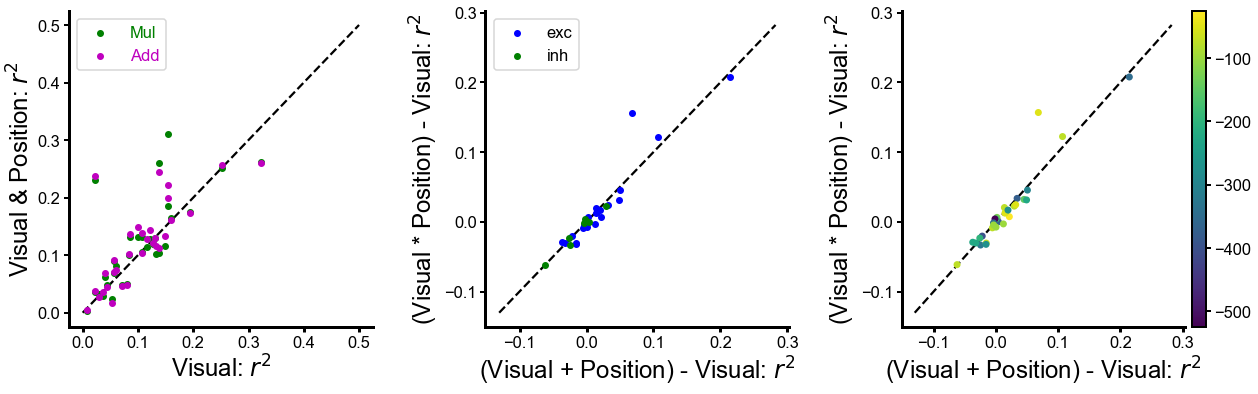

In [24]:
a = 0; l = 0
fontsize=24
bin_length=40
fig, axs = plt.subplots(1,3,figsize=(18,6))
ax = axs[0]
xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, .51)
ax.scatter(xvals,yvals,30,c='g', label='Mul')
ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],.5),np.linspace(lims[0],.5),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,.6,.1))
ax.set_yticklabels(np.round(np.arange(0,.6,.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)

xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax = axs[1]
ax.scatter(xvals[(exc)&(tuning_sig2)],yvals[(exc)&(tuning_sig2)],30,c='b',label='exc')
ax.scatter(xvals[(inh)&(tuning_sig2)],yvals[(inh)&(tuning_sig2)],30,c='g',label='inh')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
ax.legend()
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)



xvals = np.nanmean(r2_Add,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0) - np.nanmean(r2_Vis,axis=0)# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax = axs[2]
p = ax.scatter(xvals[tuning_sig2],yvals[tuning_sig2],30,c=depth[tuning_sig2])
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
cbar = add_colorbar(p)
plt.tight_layout()
# fig.savefig(fig_dir/'VisMov_ADDMUL_CTypeDepth_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



In [81]:
vloss_Vis = np.mean(GLM_VisMov_Vis['vloss_trace_all'][:,:100],axis=1)/np.mean(GLM_VisMov_Vis['vloss_trace_all'][:,:100])
vloss_Add = np.mean(GLM_VisMov_Add['vloss_trace_all'][:,:100],axis=1)/np.mean(GLM_VisMov_Add['vloss_trace_all'][:,:100])
vloss_Mul = np.mean(GLM_VisMov_Mul['vloss_trace_all'][:,:100],axis=1)/np.mean(GLM_VisMov_Mul['vloss_trace_all'][:,:100])


In [23]:
Nepochs = 5000
params['NKfold']=1
vloss_Mot = np.zeros((params['NKfold'],output_size))
vloss_Vis = np.zeros((params['NKfold'],output_size))
vloss_Add = np.zeros((params['NKfold'],output_size))
vloss_Mul = np.zeros((params['NKfold'],output_size))
vloss_AddMul = np.zeros((params['NKfold'],output_size))
for Kfold in range(params['NKfold']):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    # GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs,Kfold))
    GLM_VisMov_Vis = ioh5.load(params_m1['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
    GLM_VisMov_Add = ioh5.load(params_m2['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    GLM_VisMov_Mul = ioh5.load(params_m3['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 3, Nepochs,Kfold))
    # GLM_VisMov_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))
    # r2_Mot[Kfold] = GLM_VisMov_Mot['r2_test'].copy()
    vloss_Vis[Kfold] = np.mean(GLM_VisMov_Vis['vloss_trace_all'][:,-100:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Add[Kfold] = np.mean(GLM_VisMov_Add['vloss_trace_all'][:,-100:],axis=1)/np.var(data['test_nsp'],axis=0)
    vloss_Mul[Kfold] = np.mean(GLM_VisMov_Mul['vloss_trace_all'][:,-100:],axis=1)/np.var(data['test_nsp'],axis=0)
    # r2_AddMul[Kfold] = GLM_VisMov_AddMul['r2_test'].copy()

Done Loading Unaligned data


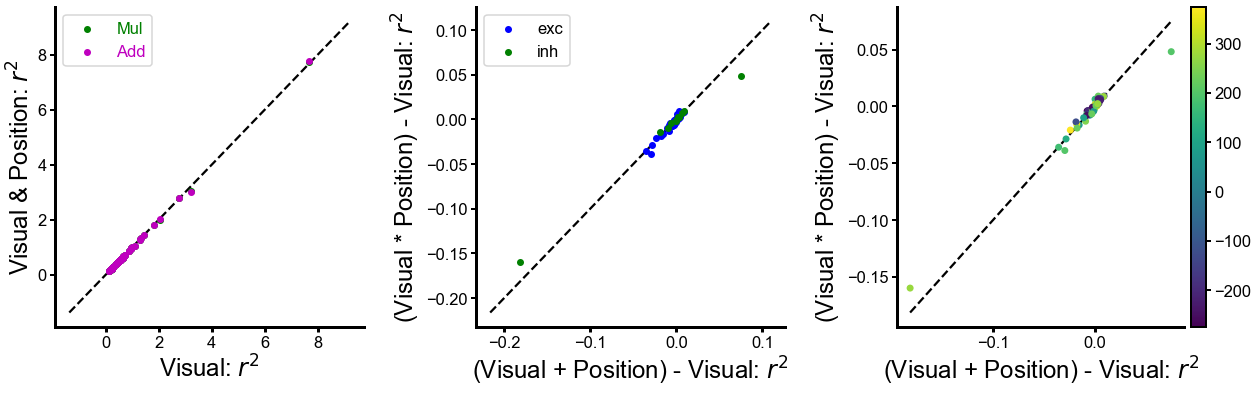

In [42]:
a = 0; l = 0
fontsize=24
bin_length=40
fig, axs = plt.subplots(1,3,figsize=(18,6))
ax = axs[0]
xvals = np.nanmean(vloss_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
yvals = np.nanmean(vloss_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals2 = np.nanmean(vloss_Add,axis=0)[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min,lim_max)
ax.scatter(xvals,yvals,30,c='g', label='Mul')
ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
# ax.set_yticks(np.arange(0,.6,.1))
# ax.set_yticklabels(np.round(np.arange(0,.6,.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)

xvals = (np.nanmean(vloss_Add,axis=0) - np.nanmean(vloss_Vis,axis=0))# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals = (np.nanmean(vloss_Mul,axis=0) - np.nanmean(vloss_Vis,axis=0))# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals[tuning_sig2],yvals[tuning_sig2]))+1.5*np.nanstd((xvals[tuning_sig2],yvals[tuning_sig2]))
lim_min = np.nanmin((xvals[tuning_sig2],yvals[tuning_sig2]))-1.5*np.nanstd((xvals[tuning_sig2],yvals[tuning_sig2]))
lims = (lim_min, lim_max)
ax = axs[1]
ax.scatter(xvals[(exc)&(tuning_sig2)],yvals[(exc)&(tuning_sig2)],30,c='b',label='exc')
ax.scatter(xvals[(inh)&(tuning_sig2)],yvals[(inh)&(tuning_sig2)],30,c='g',label='inh')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
ax.legend()
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)


xvals = (np.nanmean(vloss_Add,axis=0) - np.nanmean(vloss_Vis,axis=0))[tuning_sig2]# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals = (np.nanmean(vloss_Mul,axis=0) - np.nanmean(vloss_Vis,axis=0))[tuning_sig2]# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))#+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))#-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax = axs[2]
p = ax.scatter(xvals,yvals,30,c=depth[tuning_sig2])
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
cbar = add_colorbar(p)
plt.tight_layout()
# fig.savefig(fig_dir/'VisMov_ADDMUL_CTypeDepth_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



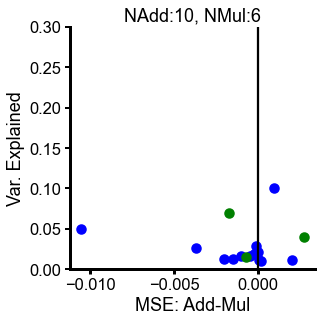

In [29]:
Kfold = 0
fig,axs = plt.subplots(1,1,figsize=(5,5))
ax = axs
diff_exc = vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)]
diff_inh = vloss_Add[Kfold][(inh)&(tuning_sig2)]-vloss_Mul[Kfold][(inh)&(tuning_sig2)]
increase_exc = 1-vloss_Vis[Kfold][(exc)&(tuning_sig2)]
increase_inh = 1-vloss_Vis[Kfold][(inh)&(tuning_sig2)]
th_exc = increase_exc>.01
th_inh = increase_inh>.01

NMul = np.sum(diff_exc[th_exc]>0)+np.sum(diff_inh[th_inh]>0)
NAdd = np.sum(diff_exc[th_exc]<0)+np.sum(diff_inh[th_inh]<0)

ax.scatter(diff_exc[th_exc],increase_exc[th_exc],c='b')
ax.scatter(diff_inh[th_inh],increase_inh[th_inh],c='g')
ax.axvline(x=0,c='k')
ax.set_ylabel('Var. Explained')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(0,.3)
plt.tight_layout()

# fig.savefig(fig_dir/'NLVis_AddMul_MSEComparison_Kfold{:02d}.png'.format(Kfold), facecolor='white', transparent=True, bbox_inches='tight')


26
31


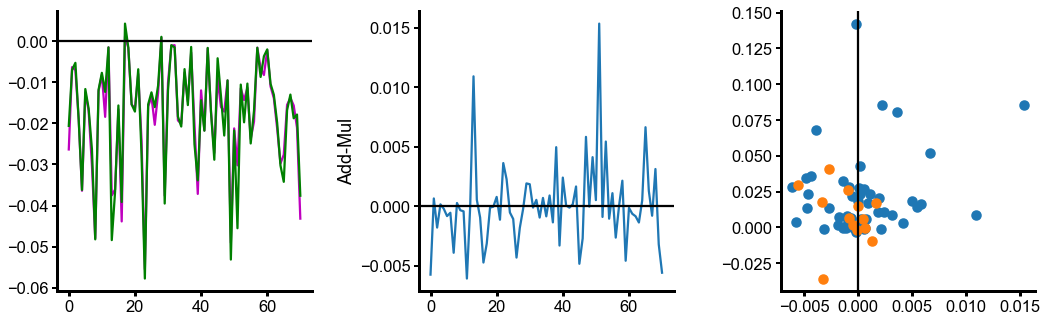

In [109]:
# plt.plot(np.nanmean(vloss_Vis,axis=0))
Kfold = 0
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax = axs[0]
ax.plot(vloss_Add[Kfold][tuning_sig2]-vloss_Vis[Kfold][tuning_sig2],'m')
ax.plot(vloss_Mul[Kfold][tuning_sig2]-vloss_Vis[Kfold][tuning_sig2],'g')
ax.axhline(y=0,color='k')

ax = axs[1]
ax.plot(vloss_Add[Kfold][tuning_sig2]-vloss_Mul[Kfold][tuning_sig2])
ax.axhline(y=0,color='k')
ax.set_ylabel('Add-Mul')

ax = axs[2]
ax.scatter(vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)],1-vloss_Vis[Kfold][(exc)&(tuning_sig2)])
ax.scatter(vloss_Add[Kfold][(inh)&(tuning_sig2)]-vloss_Mul[Kfold][(inh)&(tuning_sig2)],1-vloss_Vis[Kfold][(inh)&(tuning_sig2)])
ax.axvline(x=0,c='k')

plt.tight_layout()
print(np.sum(vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)]>0))
print(np.sum(vloss_Add[Kfold][(exc)&(tuning_sig2)]-vloss_Mul[Kfold][(exc)&(tuning_sig2)]<0))

Run on nonlinear fit for metic MSE. 

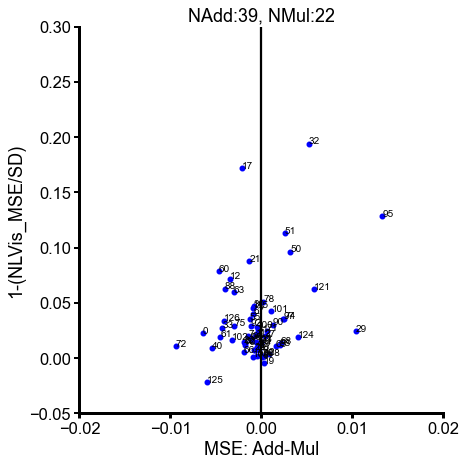

In [27]:
################################################

fig,axs = plt.subplots(1,1,figsize=(7,7))
ax = axs
diff = vloss_Add[Kfold][tuning_sig2]-vloss_Mul[Kfold][tuning_sig2]
increase = 1-vloss_Vis[Kfold][tuning_sig2]
th = increase>-10

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)

ax.scatter(diff[th],increase[th],c='b',s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('MSE: Add-Mul')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.3)
ax.set_xlim(-.02,.02)

for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
    ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

plt.tight_layout()

# # fig.savefig(params_m1['fig_dir']/'NLVis_AddMul_NB12000_Kfold{:02d}.png'.format(Kfold), facecolor='white', transparent=True, bbox_inches='tight')

fig,axs = plt.subplots(1,1,figsize=(7,7))
ax = axs
diff = r2_Mul[Kfold][tuning_sig2]-r2_Add[Kfold][tuning_sig2]
increase = 1-vloss_Vis[Kfold][tuning_sig2]
th = increase>-10

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)

ax.scatter(diff[th],increase[th],c='b',s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel('1-(NLVis_MSE/SD)')
ax.set_xlabel('R2: Mul-Add')
ax.set_title('NAdd:{}, NMul:{}'.format(NAdd,NMul))
ax.set_ylim(-.05,.3)

for i, txt in enumerate(np.arange(len(tuning_idx[th]))):
    ax.annotate(tuning_idx[th][i], (diff[th][i], increase[th][i]),fontsize=10)

plt.tight_layout() 

# fig.savefig(params_m1['fig_dir']/'NLVis_AddMul_NB12000_Kfold{:02d}.png'.format(Kfold), facecolor='white', transparent=True, bbox_inches='tight')

In [29]:
Nepochs = 5000
params['NKfold']=1
Kfold = 0
params_m1,_,_ = load_params(1,Kfold,args,debug=True)
params_m2,_,_ = load_params(2,Kfold,args,debug=True)
params_m3,_,_ = load_params(3,Kfold,args,debug=True)

move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
malph = 0*np.ones(params_FM['Ncells'],dtype=int)

mlam = np.nanargmax(GLM_VisMov_Vis['r2_test'][0],axis=0) #22*np.ones(params['Ncells'],dtype=int)# 

cellnum = np.arange(params_FM['Ncells'])

vloss_Mot = np.zeros((params['NKfold'],output_size))
vloss_Vis = np.zeros((params['NKfold'],output_size))
vloss_Add = np.zeros((params['NKfold'],output_size))
vloss_Mul = np.zeros((params['NKfold'],output_size))
r2_Vis = np.zeros((params['NKfold'],output_size))
r2_Add = np.zeros((params['NKfold'],output_size))
r2_Mul = np.zeros((params['NKfold'],output_size))
vloss_Vis[Kfold] = np.mean(GLM_VisMov_Vis['vloss_trace_all'][:,-2:],axis=1)/np.var(data['test_nsp'],axis=0) #/np.var(sp_smooth,axis=0) # 
vloss_Add[Kfold] = np.mean(GLM_VisMov_Add['vloss_trace_all'][:,-2:],axis=1)/np.var(data['test_nsp'],axis=0) #/np.var(sp_smooth,axis=0) # 
vloss_Mul[Kfold] = np.mean(GLM_VisMov_Mul['vloss_trace_all'][:,-2:],axis=1)/np.var(data['test_nsp'],axis=0) #/np.var(sp_smooth,axis=0) # 


r2_Vis[Kfold] = GLM_VisMov_Vis['r2_test'][0,mlam,cellnum].copy()
r2_Add[Kfold] = GLM_VisMov_Add['r2_test'].copy()
r2_Mul[Kfold] = GLM_VisMov_Mul['r2_test'].copy()


Done Loading Unaligned data


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [30]:
GLM_VisMov_Vis['r2_test'].shape

(128,)

In [39]:
np.var(GLM_VisMov_Vis['pred_test'],axis=0)/model_dt

array([5.84793165e-02, 2.51731653e-05, 3.93139385e-03, 4.76208404e-02,
       2.16086313e-01, 2.96134672e-09, 2.38811509e-07, 6.66494519e-02,
       4.57213596e-02, 7.99714774e-02, 2.80959576e-01, 2.62143898e+00,
       1.70810163e-01, 0.00000000e+00, 5.28923690e-01, 7.62976468e-01,
       2.98725218e-01, 8.49131882e-01, 1.79281235e-01, 7.01760916e-09,
       6.95941504e-03, 2.81829625e-01, 4.14527170e-02, 4.82387468e-03,
       2.48296931e-03, 9.42110270e-02, 5.56795418e-01, 4.15937196e-09,
       5.38296485e-03, 2.02613324e-02, 1.35612026e-01, 1.52253741e-02,
       1.43148947e+00, 7.03713074e-02, 3.45234352e-04, 1.12800323e-03,
       1.69509638e-03, 1.69892341e-01, 2.78727157e-08, 5.59401326e-02,
       5.27197868e-02, 0.00000000e+00, 2.57229097e-02, 1.01896084e-03,
       4.17404156e-03, 1.29256666e+00, 1.54768222e-03, 1.59344333e-03,
       1.20982754e+00, 3.25638195e-03, 8.84862840e-01, 3.56761783e-01,
       5.48944116e-01, 4.70770031e-01, 4.94466548e-08, 6.31016716e-02,
      